In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-15 20:34:31,604] A new study created in memory with name: no-name-d966bcf6-78c7-4d8e-ace8-2f948abd6316
[I 2025-05-15 20:44:37,721] Trial 0 finished with value: 0.025318660587072373 and parameters: {'lr': 0.010487963233556852, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34690997838053056}. Best is trial 0 with value: 0.025318660587072373.


Cross Validation Accuracies:
[0.017850812524557114, 0.023743607103824615, 0.03106098249554634, 0.034089405089616776, 0.019848495721817017]
Mean Cross Validation Accuracy:
0.025318660587072373
Standard Deviation of Cross Validation Accuracy:
0.006294004636833865


[I 2025-05-15 20:56:57,375] Trial 1 finished with value: 1.2813056021928788 and parameters: {'lr': 0.14079574727547237, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1688359945034964}. Best is trial 0 with value: 0.025318660587072373.


Cross Validation Accuracies:
[2.8270556926727295, 0.4763065278530121, 0.18227724730968475, 1.02659010887146, 1.8942984342575073]
Mean Cross Validation Accuracy:
1.2813056021928788
Standard Deviation of Cross Validation Accuracy:
0.9680775146076225


[I 2025-05-15 21:12:03,469] Trial 2 finished with value: 0.41759504079818727 and parameters: {'lr': 0.7943146995754088, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4888326874439882}. Best is trial 0 with value: 0.025318660587072373.


Cross Validation Accuracies:
[0.4071085751056671, 0.4131094217300415, 0.42638275027275085, 0.4232066869735718, 0.41816776990890503]
Mean Cross Validation Accuracy:
0.41759504079818727
Standard Deviation of Cross Validation Accuracy:
0.006915622464915517


[I 2025-05-15 21:25:09,171] Trial 3 finished with value: 0.025190039724111556 and parameters: {'lr': 0.003876505351839524, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.30029091553196385}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[0.020627986639738083, 0.024468589574098587, 0.028085745871067047, 0.03400781750679016, 0.018760059028863907]
Mean Cross Validation Accuracy:
0.025190039724111556
Standard Deviation of Cross Validation Accuracy:
0.005455562107043946


[I 2025-05-15 21:38:26,628] Trial 4 finished with value: 3.859561634063721 and parameters: {'lr': 0.04900301907997138, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20620702186846215}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[5.4185872077941895, 1.3473286628723145, 3.0884017944335938, 5.451540470123291, 3.991950035095215]
Mean Cross Validation Accuracy:
3.859561634063721
Standard Deviation of Cross Validation Accuracy:
1.5419783424247204


[I 2025-05-15 21:50:56,835] Trial 5 finished with value: 0.6875793933868408 and parameters: {'lr': 0.10773157523251618, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.15695614111859466}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[0.923317015171051, 0.3735527992248535, 0.4789455235004425, 1.2868390083312988, 0.3752426207065582]
Mean Cross Validation Accuracy:
0.6875793933868408
Standard Deviation of Cross Validation Accuracy:
0.36176770599403757


[I 2025-05-15 22:05:24,473] Trial 6 finished with value: 44.69731216430664 and parameters: {'lr': 0.3848424860977883, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19085376132973042}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[47.863040924072266, 46.6530876159668, 44.43016815185547, 44.745765686035156, 39.794498443603516]
Mean Cross Validation Accuracy:
44.69731216430664
Standard Deviation of Cross Validation Accuracy:
2.7552928063926316


[I 2025-05-15 22:16:49,815] Trial 7 finished with value: 0.14346182644367217 and parameters: {'lr': 0.004539954489924948, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.11141524152718146}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[0.14063087105751038, 0.14047276973724365, 0.1492810994386673, 0.14784672856330872, 0.13907766342163086]
Mean Cross Validation Accuracy:
0.14346182644367217
Standard Deviation of Cross Validation Accuracy:
0.004225185406241738


[I 2025-05-15 22:28:45,233] Trial 8 finished with value: 0.0604022353887558 and parameters: {'lr': 0.6754276687305314, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13469904762082932}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[0.020605681464076042, 0.024006174877285957, 0.16197404265403748, 0.0447990745306015, 0.050626203417778015]
Mean Cross Validation Accuracy:
0.0604022353887558
Standard Deviation of Cross Validation Accuracy:
0.05208512337708928


[I 2025-05-15 22:45:43,642] Trial 9 finished with value: 0.03217850513756275 and parameters: {'lr': 0.009361511754441085, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.40812882417431195}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[0.025262795388698578, 0.024771803990006447, 0.04340459033846855, 0.04163490980863571, 0.02581842616200447]
Mean Cross Validation Accuracy:
0.03217850513756275
Standard Deviation of Cross Validation Accuracy:
0.00846859428755649


[I 2025-05-15 22:56:52,690] Trial 10 finished with value: 0.0262033361941576 and parameters: {'lr': 0.0010535660208740652, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2966051825068159}. Best is trial 3 with value: 0.025190039724111556.


Cross Validation Accuracies:
[0.024019531905651093, 0.02297935076057911, 0.02973693422973156, 0.034463196992874146, 0.019817667081952095]
Mean Cross Validation Accuracy:
0.0262033361941576
Standard Deviation of Cross Validation Accuracy:
0.005227838343870009


[I 2025-05-15 23:09:22,916] Trial 11 finished with value: 0.024635566025972368 and parameters: {'lr': 0.004840720943969313, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3181761717961186}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.01861879974603653, 0.02334086410701275, 0.02916451171040535, 0.033062893897295, 0.018990760669112206]
Mean Cross Validation Accuracy:
0.024635566025972368
Standard Deviation of Cross Validation Accuracy:
0.005679309132394242


[I 2025-05-15 23:20:22,710] Trial 12 finished with value: 0.024942339956760408 and parameters: {'lr': 0.0014590021914139583, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.27766937251152424}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.020157717168331146, 0.022876042872667313, 0.02973281778395176, 0.032951995730400085, 0.01899312622845173]
Mean Cross Validation Accuracy:
0.024942339956760408
Standard Deviation of Cross Validation Accuracy:
0.00547098905642108


[I 2025-05-15 23:30:57,889] Trial 13 finished with value: 0.025313207507133485 and parameters: {'lr': 0.0010303037827470516, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.25931782631799455}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.019658764824271202, 0.02440968155860901, 0.028610486537218094, 0.03342882916331291, 0.020458275452256203]
Mean Cross Validation Accuracy:
0.025313207507133485
Standard Deviation of Cross Validation Accuracy:
0.005159356749041319


[I 2025-05-15 23:42:27,638] Trial 14 finished with value: 0.02507513202726841 and parameters: {'lr': 0.003534752113460282, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3755166825899055}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.02056746929883957, 0.023755699396133423, 0.02836078219115734, 0.033619657158851624, 0.019072052091360092]
Mean Cross Validation Accuracy:
0.02507513202726841
Standard Deviation of Cross Validation Accuracy:
0.005327312665537772


[I 2025-05-15 23:53:53,783] Trial 15 finished with value: 0.025730730220675468 and parameters: {'lr': 0.0163525973853881, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24617585963724875}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.018622038885951042, 0.025725485756993294, 0.031159043312072754, 0.033193979412317276, 0.019953103736042976]
Mean Cross Validation Accuracy:
0.025730730220675468
Standard Deviation of Cross Validation Accuracy:
0.005815172556467942


[I 2025-05-16 00:06:09,704] Trial 16 finished with value: 0.02514333128929138 and parameters: {'lr': 0.002152815722499816, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4393871298041133}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.022744709625840187, 0.022920973598957062, 0.02849038876593113, 0.03275737538933754, 0.01880320906639099]
Mean Cross Validation Accuracy:
0.02514333128929138
Standard Deviation of Cross Validation Accuracy:
0.004900323881109464


[I 2025-05-16 00:18:28,766] Trial 17 finished with value: 0.030589039251208306 and parameters: {'lr': 0.023957012544753784, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3220823582632418}. Best is trial 11 with value: 0.024635566025972368.


Cross Validation Accuracies:
[0.02675107680261135, 0.035000745207071304, 0.03229273483157158, 0.03161211311817169, 0.0272885262966156]
Mean Cross Validation Accuracy:
0.030589039251208306
Standard Deviation of Cross Validation Accuracy:
0.003131636943487684


[I 2025-05-16 00:31:39,708] Trial 18 finished with value: 0.02447201795876026 and parameters: {'lr': 0.0019024183507149596, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24733892386463205}. Best is trial 18 with value: 0.02447201795876026.


Cross Validation Accuracies:
[0.018854372203350067, 0.02331353910267353, 0.02872863970696926, 0.03336481750011444, 0.018098721280694008]
Mean Cross Validation Accuracy:
0.02447201795876026
Standard Deviation of Cross Validation Accuracy:
0.00584328058593738


[I 2025-05-16 00:44:49,321] Trial 19 finished with value: 0.025640875473618506 and parameters: {'lr': 0.007669184524557532, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22408681631133726}. Best is trial 18 with value: 0.02447201795876026.


Cross Validation Accuracies:
[0.02235526032745838, 0.027060484513640404, 0.03023771569132805, 0.03169409930706024, 0.01685681752860546]
Mean Cross Validation Accuracy:
0.025640875473618506
Standard Deviation of Cross Validation Accuracy:
0.0054358566843034865


[I 2025-05-16 00:58:42,406] Trial 20 finished with value: 0.0459474079310894 and parameters: {'lr': 0.04052718930323827, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.35784033605554105}. Best is trial 18 with value: 0.02447201795876026.


Cross Validation Accuracies:
[0.04215278849005699, 0.04406137391924858, 0.051711831241846085, 0.05008021369576454, 0.04173083230853081]
Mean Cross Validation Accuracy:
0.0459474079310894
Standard Deviation of Cross Validation Accuracy:
0.004148359448528153


[I 2025-05-16 01:12:55,408] Trial 21 finished with value: 0.024614330381155014 and parameters: {'lr': 0.002136121898882934, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2729354554681732}. Best is trial 18 with value: 0.02447201795876026.


Cross Validation Accuracies:
[0.01880265213549137, 0.02347426302731037, 0.02748611383140087, 0.03323317691683769, 0.020075445994734764]
Mean Cross Validation Accuracy:
0.024614330381155014
Standard Deviation of Cross Validation Accuracy:
0.005257537158527122


[I 2025-05-16 01:24:48,657] Trial 22 finished with value: 0.024363145977258683 and parameters: {'lr': 0.002825653722867213, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2397390649660616}. Best is trial 22 with value: 0.024363145977258683.


Cross Validation Accuracies:
[0.017603382468223572, 0.02416047267615795, 0.028394335880875587, 0.032029181718826294, 0.019628357142210007]
Mean Cross Validation Accuracy:
0.024363145977258683
Standard Deviation of Cross Validation Accuracy:
0.005351117649754644


[I 2025-05-16 01:37:17,139] Trial 23 finished with value: 0.024924855679273605 and parameters: {'lr': 0.0020353911950927073, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23898292256706194}. Best is trial 22 with value: 0.024363145977258683.


Cross Validation Accuracies:
[0.019037222489714622, 0.023981831967830658, 0.0288619976490736, 0.033890970051288605, 0.01885225623846054]
Mean Cross Validation Accuracy:
0.024924855679273605
Standard Deviation of Cross Validation Accuracy:
0.005802107825370325


[I 2025-05-16 01:50:15,186] Trial 24 finished with value: 0.02461194396018982 and parameters: {'lr': 0.0018849845546541726, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2650534633841622}. Best is trial 22 with value: 0.024363145977258683.


Cross Validation Accuracies:
[0.018781958147883415, 0.022427089512348175, 0.0296615120023489, 0.031932901591062546, 0.02025625854730606]
Mean Cross Validation Accuracy:
0.02461194396018982
Standard Deviation of Cross Validation Accuracy:
0.0052312307727987615


[I 2025-05-16 02:02:38,164] Trial 25 finished with value: 0.024542577937245368 and parameters: {'lr': 0.003033264415883904, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20387913233294921}. Best is trial 22 with value: 0.024363145977258683.


Cross Validation Accuracies:
[0.018560310825705528, 0.02298763208091259, 0.028470011427998543, 0.03145446628332138, 0.021240469068288803]
Mean Cross Validation Accuracy:
0.024542577937245368
Standard Deviation of Cross Validation Accuracy:
0.00473937197791628


[I 2025-05-16 02:17:04,134] Trial 26 finished with value: 0.02385617084801197 and parameters: {'lr': 0.005570858106557198, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1968034920528856}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.0217997208237648, 0.02349035255610943, 0.025927744805812836, 0.029430324211716652, 0.018632711842656136]
Mean Cross Validation Accuracy:
0.02385617084801197
Standard Deviation of Cross Validation Accuracy:
0.0036608725214158605


[I 2025-05-16 02:28:38,370] Trial 27 finished with value: 0.026585505157709122 and parameters: {'lr': 0.007065948058226235, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17671681605821488}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.019960781559348106, 0.028750771656632423, 0.02861923724412918, 0.031011996790766716, 0.024584738537669182]
Mean Cross Validation Accuracy:
0.026585505157709122
Standard Deviation of Cross Validation Accuracy:
0.0039066175449042955


[I 2025-05-16 02:40:19,485] Trial 28 finished with value: 1.1934930801391601 and parameters: {'lr': 0.015376061509109933, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13997256955781867}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[1.3785247802734375, 0.8446800708770752, 1.2681893110275269, 1.3631125688552856, 1.1129586696624756]
Mean Cross Validation Accuracy:
1.1934930801391601
Standard Deviation of Cross Validation Accuracy:
0.19836498411621323


[I 2025-05-16 02:53:13,589] Trial 29 finished with value: 0.07027681320905685 and parameters: {'lr': 0.0064023338114605624, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.23014762343471973}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.04680591821670532, 0.06872551888227463, 0.06629284471273422, 0.11461179703474045, 0.05494798719882965]
Mean Cross Validation Accuracy:
0.07027681320905685
Standard Deviation of Cross Validation Accuracy:
0.023536036745745594


[I 2025-05-16 03:04:50,213] Trial 30 finished with value: 0.3733489364385605 and parameters: {'lr': 0.018604968668779007, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10470034516694013}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.5967741012573242, 0.3127737045288086, 0.3161621689796448, 0.21031545102596283, 0.430719256401062]
Mean Cross Validation Accuracy:
0.3733489364385605
Standard Deviation of Cross Validation Accuracy:
0.13170403209164977


[I 2025-05-16 03:15:50,806] Trial 31 finished with value: 0.025031586363911628 and parameters: {'lr': 0.0029305320973143792, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20589580524387055}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.018877126276493073, 0.02393450029194355, 0.02937028557062149, 0.03195837512612343, 0.021017644554376602]
Mean Cross Validation Accuracy:
0.025031586363911628
Standard Deviation of Cross Validation Accuracy:
0.0049395833636021605


[I 2025-05-16 03:26:40,801] Trial 32 finished with value: 0.024590333551168443 and parameters: {'lr': 0.002925047108510428, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2055918918275983}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.01792270317673683, 0.02433287911117077, 0.029348058626055717, 0.03317360579967499, 0.018174421042203903]
Mean Cross Validation Accuracy:
0.024590333551168443
Standard Deviation of Cross Validation Accuracy:
0.006033175304955077


[I 2025-05-16 03:39:51,717] Trial 33 finished with value: 0.03465101383626461 and parameters: {'lr': 0.010956876485292153, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17269041149560227}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.031392332166433334, 0.041263412684202194, 0.027869170531630516, 0.039461519569158554, 0.03326863422989845]
Mean Cross Validation Accuracy:
0.03465101383626461
Standard Deviation of Cross Validation Accuracy:
0.005007757225353751


[I 2025-05-16 03:51:35,506] Trial 34 finished with value: 0.10911577343940734 and parameters: {'lr': 0.005260610423657872, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22154083843358902}. Best is trial 26 with value: 0.02385617084801197.


Cross Validation Accuracies:
[0.10552185028791428, 0.11497792601585388, 0.1091533675789833, 0.10679309815168381, 0.10913262516260147]
Mean Cross Validation Accuracy:
0.10911577343940734
Standard Deviation of Cross Validation Accuracy:
0.0032458476316821567


[I 2025-05-16 04:02:03,240] Trial 35 finished with value: 0.023407499864697458 and parameters: {'lr': 0.003403912835498462, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18897806722251398}. Best is trial 35 with value: 0.023407499864697458.


Cross Validation Accuracies:
[0.017142247408628464, 0.021439943462610245, 0.026979880407452583, 0.03274475783109665, 0.01873067021369934]
Mean Cross Validation Accuracy:
0.023407499864697458
Standard Deviation of Cross Validation Accuracy:
0.0057435823523558655


[I 2025-05-16 04:13:17,213] Trial 36 finished with value: 0.024602337554097176 and parameters: {'lr': 0.0016285701177413774, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15449368969340463}. Best is trial 35 with value: 0.023407499864697458.


Cross Validation Accuracies:
[0.01951894536614418, 0.02361893840134144, 0.02781238965690136, 0.03312372788786888, 0.01893768645823002]
Mean Cross Validation Accuracy:
0.024602337554097176
Standard Deviation of Cross Validation Accuracy:
0.005325687745095588


[I 2025-05-16 04:26:33,792] Trial 37 finished with value: 0.1568306028842926 and parameters: {'lr': 0.01243418987093794, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18844909587345807}. Best is trial 35 with value: 0.023407499864697458.


Cross Validation Accuracies:
[0.14887142181396484, 0.12214335799217224, 0.10850322991609573, 0.09446536749601364, 0.31016963720321655]
Mean Cross Validation Accuracy:
0.1568306028842926
Standard Deviation of Cross Validation Accuracy:
0.07874562912367768


[I 2025-05-16 04:35:54,535] Trial 38 finished with value: 2.3120639085769654 and parameters: {'lr': 0.1620588038646903, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.24497866473601465}. Best is trial 35 with value: 0.023407499864697458.


Cross Validation Accuracies:
[2.540508985519409, 3.0119142532348633, 1.2193692922592163, 2.44023060798645, 2.3482964038848877]
Mean Cross Validation Accuracy:
2.3120639085769654
Standard Deviation of Cross Validation Accuracy:
0.5922328392077849


[I 2025-05-16 04:48:38,457] Trial 39 finished with value: 0.023147189244627952 and parameters: {'lr': 0.004122530409018126, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15498830730589835}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.016794366762042046, 0.02219356596469879, 0.027644149959087372, 0.030996592715382576, 0.018107270821928978]
Mean Cross Validation Accuracy:
0.023147189244627952
Standard Deviation of Cross Validation Accuracy:
0.0054498498892505


[I 2025-05-16 05:02:22,962] Trial 40 finished with value: 0.45640669465065004 and parameters: {'lr': 0.03007960899724407, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13924632286324495}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.711326003074646, 0.34590086340904236, 0.7731546759605408, 0.21704994142055511, 0.23460198938846588]
Mean Cross Validation Accuracy:
0.45640669465065004
Standard Deviation of Cross Validation Accuracy:
0.23833323679376103


[I 2025-05-16 05:15:39,929] Trial 41 finished with value: 0.024188431352376936 and parameters: {'lr': 0.001325557534424159, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15821856971834972}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.0170180294662714, 0.02325272373855114, 0.028677331283688545, 0.03230975568294525, 0.019684316590428352]
Mean Cross Validation Accuracy:
0.024188431352376936
Standard Deviation of Cross Validation Accuracy:
0.005633531631423592


[I 2025-05-16 05:28:24,940] Trial 42 finished with value: 0.0239515483379364 and parameters: {'lr': 0.0013324635315356754, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1224854697035449}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.017378415912389755, 0.02351422794163227, 0.029192494228482246, 0.030430154874920845, 0.01924244873225689]
Mean Cross Validation Accuracy:
0.0239515483379364
Standard Deviation of Cross Validation Accuracy:
0.005196398649020189


[I 2025-05-16 05:40:36,088] Trial 43 finished with value: 0.023855984210968018 and parameters: {'lr': 0.0013182498674145454, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.12852254485246128}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.017414012923836708, 0.023959428071975708, 0.02778720110654831, 0.03176037222146988, 0.018358906731009483]
Mean Cross Validation Accuracy:
0.023855984210968018
Standard Deviation of Cross Validation Accuracy:
0.005471039601719826


[I 2025-05-16 05:51:44,350] Trial 44 finished with value: 0.057375840842723846 and parameters: {'lr': 0.07606038262707826, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.12364274601781877}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.04414115101099014, 0.06555697321891785, 0.06245185434818268, 0.06207277998328209, 0.052656445652246475]
Mean Cross Validation Accuracy:
0.057375840842723846
Standard Deviation of Cross Validation Accuracy:
0.007901743899426437


[I 2025-05-16 06:04:38,071] Trial 45 finished with value: 0.1431543841958046 and parameters: {'lr': 0.004563242335955267, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11957456779526145}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.1458328515291214, 0.1388639360666275, 0.1563359498977661, 0.11951575428247452, 0.15522342920303345]
Mean Cross Validation Accuracy:
0.1431543841958046
Standard Deviation of Cross Validation Accuracy:
0.013444571233965268


[I 2025-05-16 06:15:43,615] Trial 46 finished with value: 0.024556227773427964 and parameters: {'lr': 0.0015197151794666527, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13744178526415898}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.01785479672253132, 0.02404279261827469, 0.027999015524983406, 0.034082718193531036, 0.018801815807819366]
Mean Cross Validation Accuracy:
0.024556227773427964
Standard Deviation of Cross Validation Accuracy:
0.006014862560108654


[I 2025-05-16 06:27:13,175] Trial 47 finished with value: 0.02468857690691948 and parameters: {'lr': 0.0010442294727932761, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10121057440192388}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.017765333876013756, 0.023426510393619537, 0.028336405754089355, 0.03376415744423866, 0.020150477066636086]
Mean Cross Validation Accuracy:
0.02468857690691948
Standard Deviation of Cross Validation Accuracy:
0.005758320475572185


[I 2025-05-16 06:37:13,129] Trial 48 finished with value: 0.08064874857664109 and parameters: {'lr': 0.003844421136148145, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15901382283543017}. Best is trial 39 with value: 0.023147189244627952.


Cross Validation Accuracies:
[0.076256163418293, 0.08819557726383209, 0.08817470818758011, 0.07878667116165161, 0.0718306228518486]
Mean Cross Validation Accuracy:
0.08064874857664109
Standard Deviation of Cross Validation Accuracy:
0.006543946351710034


[I 2025-05-16 06:47:06,111] Trial 49 finished with value: 0.023120116069912912 and parameters: {'lr': 0.0054876121343908, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18439201776430408}. Best is trial 49 with value: 0.023120116069912912.


Cross Validation Accuracies:
[0.016711704432964325, 0.021418403834104538, 0.028699440881609917, 0.031150126829743385, 0.017620904371142387]
Mean Cross Validation Accuracy:
0.023120116069912912
Standard Deviation of Cross Validation Accuracy:
0.00582777541961568


[I 2025-05-16 06:59:59,733] Trial 50 finished with value: 0.617025101184845 and parameters: {'lr': 0.008808493915274352, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18531532545661428}. Best is trial 49 with value: 0.023120116069912912.


Cross Validation Accuracies:
[0.6035478711128235, 0.683677077293396, 0.45914900302886963, 0.6757093667984009, 0.6630421876907349]
Mean Cross Validation Accuracy:
0.617025101184845
Standard Deviation of Cross Validation Accuracy:
0.08379785116533377


[I 2025-05-16 07:11:50,887] Trial 51 finished with value: 0.026544543355703352 and parameters: {'lr': 0.006055559606107203, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15249431451014028}. Best is trial 49 with value: 0.023120116069912912.


Cross Validation Accuracies:
[0.02168685384094715, 0.02259543351829052, 0.03553955629467964, 0.028729138895869255, 0.0241717342287302]
Mean Cross Validation Accuracy:
0.026544543355703352
Standard Deviation of Cross Validation Accuracy:
0.005108924633016891


[I 2025-05-16 07:23:29,408] Trial 52 finished with value: 0.023066193610429764 and parameters: {'lr': 0.002457345296575067, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11998899269094034}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.01731310971081257, 0.02207673154771328, 0.026318049058318138, 0.03135058283805847, 0.01827249489724636]
Mean Cross Validation Accuracy:
0.023066193610429764
Standard Deviation of Cross Validation Accuracy:
0.005220387449436639


[I 2025-05-16 07:33:11,963] Trial 53 finished with value: 0.02377541922032833 and parameters: {'lr': 0.0039047824877073093, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.49726527841791607}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.017171891406178474, 0.025024183094501495, 0.026573093608021736, 0.03193241357803345, 0.018175514414906502]
Mean Cross Validation Accuracy:
0.02377541922032833
Standard Deviation of Cross Validation Accuracy:
0.0054934226774692296


[I 2025-05-16 07:43:41,219] Trial 54 finished with value: 0.02403712198138237 and parameters: {'lr': 0.002498841038254157, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4638019075590663}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.01764310896396637, 0.022425150498747826, 0.027987699955701828, 0.03294776380062103, 0.019181886687874794]
Mean Cross Validation Accuracy:
0.02403712198138237
Standard Deviation of Cross Validation Accuracy:
0.005693184842335207


[I 2025-05-16 07:54:27,473] Trial 55 finished with value: 0.024309345334768296 and parameters: {'lr': 0.004179415362784939, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.41360474275089804}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.01856374926865101, 0.022344140335917473, 0.027383942157030106, 0.03265593200922012, 0.020598962903022766]
Mean Cross Validation Accuracy:
0.024309345334768296
Standard Deviation of Cross Validation Accuracy:
0.005094300685391388


[I 2025-05-16 08:05:04,047] Trial 56 finished with value: 0.02482895590364933 and parameters: {'lr': 0.003551414189993935, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.49461943309424833}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.01846233569085598, 0.023294877260923386, 0.027532396838068962, 0.032492004334926605, 0.022363165393471718]
Mean Cross Validation Accuracy:
0.02482895590364933
Standard Deviation of Cross Validation Accuracy:
0.00479579560035862


[I 2025-05-16 08:15:04,987] Trial 57 finished with value: 0.024100228771567346 and parameters: {'lr': 0.002383431752998833, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17304982421002216}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.021091479808092117, 0.021885858848690987, 0.02733212523162365, 0.03151532635092735, 0.018676353618502617]
Mean Cross Validation Accuracy:
0.024100228771567346
Standard Deviation of Cross Validation Accuracy:
0.004664831250893022


[I 2025-05-16 08:26:01,685] Trial 58 finished with value: 0.023916110396385193 and parameters: {'lr': 0.0035673187319545593, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29341538047651006}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.018236426636576653, 0.022007839754223824, 0.02904258482158184, 0.030847985297441483, 0.019445715472102165]
Mean Cross Validation Accuracy:
0.023916110396385193
Standard Deviation of Cross Validation Accuracy:
0.005103261014494805


[I 2025-05-16 08:36:19,260] Trial 59 finished with value: 58.829582595825194 and parameters: {'lr': 0.9679642649025537, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4736133040821763}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[24.912763595581055, 19.32665252685547, 60.933467864990234, 75.798583984375, 113.17644500732422]
Mean Cross Validation Accuracy:
58.829582595825194
Standard Deviation of Cross Validation Accuracy:
34.516045226688576


[I 2025-05-16 08:47:03,011] Trial 60 finished with value: 0.041952519491314885 and parameters: {'lr': 0.0016755457880446613, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.39582606850755814}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.040664248168468475, 0.07224836945533752, 0.03314797952771187, 0.039331819862127304, 0.024370180442929268]
Mean Cross Validation Accuracy:
0.041952519491314885
Standard Deviation of Cross Validation Accuracy:
0.016205090588906505


[I 2025-05-16 08:57:45,620] Trial 61 finished with value: 0.02313329018652439 and parameters: {'lr': 0.005764589115411831, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19227467362726608}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.019595669582486153, 0.02108580246567726, 0.02483147569000721, 0.02837110310792923, 0.021782400086522102]
Mean Cross Validation Accuracy:
0.02313329018652439
Standard Deviation of Cross Validation Accuracy:
0.003125712327495751


[I 2025-05-16 09:07:58,234] Trial 62 finished with value: 0.032963966578245164 and parameters: {'lr': 0.008871553374996018, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.12661719438501629}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.028998522087931633, 0.03018149547278881, 0.03809419274330139, 0.03627225011587143, 0.03127337247133255]
Mean Cross Validation Accuracy:
0.032963966578245164
Standard Deviation of Cross Validation Accuracy:
0.0035662014626978546


[I 2025-05-16 09:18:25,409] Trial 63 finished with value: 0.023268678039312363 and parameters: {'lr': 0.004826626449723026, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21580228234400192}. Best is trial 52 with value: 0.023066193610429764.


Cross Validation Accuracies:
[0.016608169302344322, 0.023484645411372185, 0.026253553107380867, 0.03022708371281624, 0.0197699386626482]
Mean Cross Validation Accuracy:
0.023268678039312363
Standard Deviation of Cross Validation Accuracy:
0.004774496506562137


[I 2025-05-16 09:28:55,596] Trial 64 finished with value: 0.021789752691984177 and parameters: {'lr': 0.0047886414965078615, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2174581406266367}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.0175443347543478, 0.021585926413536072, 0.024784892797470093, 0.02706979028880596, 0.017963819205760956]
Mean Cross Validation Accuracy:
0.021789752691984177
Standard Deviation of Cross Validation Accuracy:
0.003729679528681697


[I 2025-05-16 09:40:23,516] Trial 65 finished with value: 0.023705819621682167 and parameters: {'lr': 0.006948849918742668, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.22030323833962734}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.017959197983145714, 0.022688621655106544, 0.027927450835704803, 0.03138177841901779, 0.018572049215435982]
Mean Cross Validation Accuracy:
0.023705819621682167
Standard Deviation of Cross Validation Accuracy:
0.005237489171527794


[I 2025-05-16 09:48:58,978] Trial 66 finished with value: 0.02313283979892731 and parameters: {'lr': 0.005101235873536603, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1845693540036612}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.02004869654774666, 0.023597998544573784, 0.02907896228134632, 0.025801217183470726, 0.017137324437499046]
Mean Cross Validation Accuracy:
0.02313283979892731
Standard Deviation of Cross Validation Accuracy:
0.0041988361993259135


[I 2025-05-16 09:58:28,173] Trial 67 finished with value: 0.03675541467964649 and parameters: {'lr': 0.011551144121751232, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21482977604641407}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.03197382763028145, 0.0388069823384285, 0.042155828326940536, 0.042153555899858475, 0.028686879202723503]
Mean Cross Validation Accuracy:
0.03675541467964649
Standard Deviation of Cross Validation Accuracy:
0.0054859486965667505


[I 2025-05-16 10:07:32,348] Trial 68 finished with value: 0.02382904924452305 and parameters: {'lr': 0.00500996901124103, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16687502405764099}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.016834275797009468, 0.026912540197372437, 0.02490239590406418, 0.030214564874768257, 0.020281469449400902]
Mean Cross Validation Accuracy:
0.02382904924452305
Standard Deviation of Cross Validation Accuracy:
0.004752830259051082


[I 2025-05-16 10:18:38,903] Trial 69 finished with value: 0.4939925789833069 and parameters: {'lr': 0.007324205500543062, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.14664880885522008}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.46477553248405457, 0.4192511737346649, 0.5332189798355103, 0.5266199707984924, 0.5260972380638123]
Mean Cross Validation Accuracy:
0.4939925789833069
Standard Deviation of Cross Validation Accuracy:
0.04488625584705423


[I 2025-05-16 10:29:04,592] Trial 70 finished with value: 0.02377549186348915 and parameters: {'lr': 0.005570544402544253, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25769452966403533}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.018865935504436493, 0.022613683715462685, 0.02736879140138626, 0.032278113067150116, 0.0177509356290102]
Mean Cross Validation Accuracy:
0.02377549186348915
Standard Deviation of Cross Validation Accuracy:
0.005421350173894523


[I 2025-05-16 10:37:49,777] Trial 71 finished with value: 0.022754337638616562 and parameters: {'lr': 0.0030569105592115303, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19366499494577247}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.01799539104104042, 0.021239537745714188, 0.0268750861287117, 0.029360981658101082, 0.01830069161951542]
Mean Cross Validation Accuracy:
0.022754337638616562
Standard Deviation of Cross Validation Accuracy:
0.0045914151983105595


[I 2025-05-16 10:46:39,969] Trial 72 finished with value: 0.022848449274897577 and parameters: {'lr': 0.004518706704360589, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1802412422465663}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.016076670959591866, 0.022498970851302147, 0.026624567806720734, 0.029485542327165604, 0.019556494429707527]
Mean Cross Validation Accuracy:
0.022848449274897577
Standard Deviation of Cross Validation Accuracy:
0.004798461394526717


[I 2025-05-16 10:54:48,373] Trial 73 finished with value: 0.023135235905647276 and parameters: {'lr': 0.0022771099034826917, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.18051974437551163}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.01660856045782566, 0.022946743294596672, 0.028012992814183235, 0.030803494155406952, 0.01730438880622387]
Mean Cross Validation Accuracy:
0.023135235905647276
Standard Deviation of Cross Validation Accuracy:
0.005643163949527785


[I 2025-05-16 11:02:49,027] Trial 74 finished with value: 0.02307884842157364 and parameters: {'lr': 0.002188918142206446, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.18175386754061368}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.017550189048051834, 0.02129329741001129, 0.026788456365466118, 0.03195686638355255, 0.0178054329007864]
Mean Cross Validation Accuracy:
0.02307884842157364
Standard Deviation of Cross Validation Accuracy:
0.00555236115844083


[I 2025-05-16 11:09:53,015] Trial 75 finished with value: 0.024294272437691687 and parameters: {'lr': 0.0026589398568920724, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19904901972684333}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.02272859402000904, 0.022097310051321983, 0.026792822405695915, 0.031115423887968063, 0.01873721182346344]
Mean Cross Validation Accuracy:
0.024294272437691687
Standard Deviation of Cross Validation Accuracy:
0.004264499369331616


[I 2025-05-16 11:16:04,438] Trial 76 finished with value: 0.13977772891521453 and parameters: {'lr': 0.27211124518166485, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16611795167855084}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.1323961615562439, 0.14281970262527466, 0.144426628947258, 0.13794051110744476, 0.14130564033985138]
Mean Cross Validation Accuracy:
0.13977772891521453
Standard Deviation of Cross Validation Accuracy:
0.00426762919735006


[I 2025-05-16 11:23:02,685] Trial 77 finished with value: 0.043583476543426515 and parameters: {'lr': 0.014159650031240898, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.23091122720325402}. Best is trial 64 with value: 0.021789752691984177.


Cross Validation Accuracies:
[0.0518958680331707, 0.034887753427028656, 0.04018869623541832, 0.04996994882822037, 0.040975116193294525]
Mean Cross Validation Accuracy:
0.043583476543426515
Standard Deviation of Cross Validation Accuracy:
0.006384771853340549


[I 2025-05-16 11:31:10,954] Trial 78 finished with value: 0.01838439330458641 and parameters: {'lr': 0.001905838942837697, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1949477853180807}. Best is trial 78 with value: 0.01838439330458641.


Cross Validation Accuracies:
[0.013754978775978088, 0.020052894949913025, 0.018106136471033096, 0.024240585044026375, 0.015767371281981468]
Mean Cross Validation Accuracy:
0.01838439330458641
Standard Deviation of Cross Validation Accuracy:
0.0036176398228527583


[I 2025-05-16 11:39:04,547] Trial 79 finished with value: 0.02034570313990116 and parameters: {'lr': 0.0018202691896533623, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.20683009721711637}. Best is trial 78 with value: 0.01838439330458641.


Cross Validation Accuracies:
[0.018740814179182053, 0.02328268438577652, 0.02290848083794117, 0.017765600234270096, 0.019030936062335968]
Mean Cross Validation Accuracy:
0.02034570313990116
Standard Deviation of Cross Validation Accuracy:
0.0022871335954127415


[I 2025-05-16 11:47:01,743] Trial 80 finished with value: 0.019183626025915147 and parameters: {'lr': 0.0018967226601840376, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.20938280545539534}. Best is trial 78 with value: 0.01838439330458641.


Cross Validation Accuracies:
[0.02224074676632881, 0.021553264930844307, 0.019566373899579048, 0.021123874932527542, 0.01143386960029602]
Mean Cross Validation Accuracy:
0.019183626025915147
Standard Deviation of Cross Validation Accuracy:
0.003973184168196864


[I 2025-05-16 11:53:42,427] Trial 81 finished with value: 0.019588466361165048 and parameters: {'lr': 0.0018852835810901816, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21276994823163017}. Best is trial 78 with value: 0.01838439330458641.


Cross Validation Accuracies:
[0.017689639702439308, 0.026053357869386673, 0.02088509500026703, 0.02210797369480133, 0.011206265538930893]
Mean Cross Validation Accuracy:
0.019588466361165048
Standard Deviation of Cross Validation Accuracy:
0.004973747451353216


[I 2025-05-16 11:59:48,119] Trial 82 finished with value: 0.01521169375628233 and parameters: {'lr': 0.001880555165008262, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2090095399938167}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.013658237643539906, 0.01719057746231556, 0.0178495105355978, 0.01615128479897976, 0.011208858340978622]
Mean Cross Validation Accuracy:
0.01521169375628233
Standard Deviation of Cross Validation Accuracy:
0.0024573484354883704


[I 2025-05-16 12:06:17,865] Trial 83 finished with value: 0.017912577278912066 and parameters: {'lr': 0.001826579785948251, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.23529649522782226}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.017141684889793396, 0.019073503091931343, 0.019851239398121834, 0.019072968512773514, 0.01442349050194025]
Mean Cross Validation Accuracy:
0.017912577278912066
Standard Deviation of Cross Validation Accuracy:
0.0019606462702005446


[I 2025-05-16 12:12:51,061] Trial 84 finished with value: 0.022304251790046692 and parameters: {'lr': 0.0017797885112723873, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.23331389449061937}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.023922938853502274, 0.02488923817873001, 0.02373374253511429, 0.020539812743663788, 0.0184355266392231]
Mean Cross Validation Accuracy:
0.022304251790046692
Standard Deviation of Cross Validation Accuracy:
0.0024259441737322003


[I 2025-05-16 12:18:51,662] Trial 85 finished with value: 0.01718520577996969 and parameters: {'lr': 0.0019635878478908037, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2529272247258509}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.013775824569165707, 0.025582551956176758, 0.018690820783376694, 0.016615675762295723, 0.01126115582883358]
Mean Cross Validation Accuracy:
0.01718520577996969
Standard Deviation of Cross Validation Accuracy:
0.004895404208984472


[I 2025-05-16 12:25:06,733] Trial 86 finished with value: 0.031128594651818275 and parameters: {'lr': 0.0018236582509895017, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.28188118379421573}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.01820288971066475, 0.0374535471200943, 0.02729739062488079, 0.03270070627331734, 0.0399884395301342]
Mean Cross Validation Accuracy:
0.031128594651818275
Standard Deviation of Cross Validation Accuracy:
0.007781071680250825


[I 2025-05-16 12:30:37,623] Trial 87 finished with value: 0.018399634025990964 and parameters: {'lr': 0.0012264473503611198, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.23467536617205498}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.01474680658429861, 0.02392309159040451, 0.020191030576825142, 0.016099466010928154, 0.017037775367498398]
Mean Cross Validation Accuracy:
0.018399634025990964
Standard Deviation of Cross Validation Accuracy:
0.003292605815770472


[I 2025-05-16 12:36:18,878] Trial 88 finished with value: 0.022118571773171426 and parameters: {'lr': 0.0011024074364358203, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25305025919387253}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.0183351319283247, 0.018108537420630455, 0.032223474234342575, 0.024384580552577972, 0.017541134729981422]
Mean Cross Validation Accuracy:
0.022118571773171426
Standard Deviation of Cross Validation Accuracy:
0.0056319014904494


[I 2025-05-16 12:42:03,867] Trial 89 finished with value: 0.018355320580303668 and parameters: {'lr': 0.001242658326220366, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.26822342401289645}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.018031831830739975, 0.021578030660748482, 0.02193582057952881, 0.018703890964388847, 0.011527028866112232]
Mean Cross Validation Accuracy:
0.018355320580303668
Standard Deviation of Cross Validation Accuracy:
0.0037431952801023575


[I 2025-05-16 12:47:40,078] Trial 90 finished with value: 0.016821479611098766 and parameters: {'lr': 0.001213028703739707, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.24889733451658025}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.021525204181671143, 0.017138993367552757, 0.01699034497141838, 0.016824871301651, 0.01162798423320055]
Mean Cross Validation Accuracy:
0.016821479611098766
Standard Deviation of Cross Validation Accuracy:
0.003137730424210296


[I 2025-05-16 12:53:18,502] Trial 91 finished with value: 0.019060550816357137 and parameters: {'lr': 0.0012156358555365807, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2721313946257063}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.013054384849965572, 0.01802542433142662, 0.02594641037285328, 0.02169926092028618, 0.01657727360725403]
Mean Cross Validation Accuracy:
0.019060550816357137
Standard Deviation of Cross Validation Accuracy:
0.004420181783530227


[I 2025-05-16 12:58:52,926] Trial 92 finished with value: 0.01993322167545557 and parameters: {'lr': 0.0011703899212970928, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2705234230319656}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.01943645253777504, 0.016790146008133888, 0.027913235127925873, 0.02106310985982418, 0.01446316484361887]
Mean Cross Validation Accuracy:
0.01993322167545557
Standard Deviation of Cross Validation Accuracy:
0.004582673629683171


[I 2025-05-16 13:04:24,860] Trial 93 finished with value: 0.01856497786939144 and parameters: {'lr': 0.0013035402940990391, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.31840143782005215}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.019872207194566727, 0.01946123130619526, 0.022153101861476898, 0.01590048335492611, 0.015437865629792213]
Mean Cross Validation Accuracy:
0.01856497786939144
Standard Deviation of Cross Validation Accuracy:
0.0025402800826218874


[I 2025-05-16 13:09:48,781] Trial 94 finished with value: 0.023534734174609183 and parameters: {'lr': 0.0014399104394049796, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3264046004403766}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.01476217433810234, 0.021388642489910126, 0.026190245524048805, 0.021617572754621506, 0.033715035766363144]
Mean Cross Validation Accuracy:
0.023534734174609183
Standard Deviation of Cross Validation Accuracy:
0.006259861093356424


[I 2025-05-16 13:14:24,905] Trial 95 finished with value: 0.019843346625566482 and parameters: {'lr': 0.0012118972660453296, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.30995444885831563}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.013884153217077255, 0.025805948302149773, 0.02308453805744648, 0.020344384014606476, 0.01609770953655243]
Mean Cross Validation Accuracy:
0.019843346625566482
Standard Deviation of Cross Validation Accuracy:
0.004378373268675966


[I 2025-05-16 13:17:29,630] Trial 96 finished with value: 0.025382688641548155 and parameters: {'lr': 0.0013310409939794633, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.28958264124914995}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.02005198784172535, 0.022438284009695053, 0.03008335269987583, 0.03303441032767296, 0.02130540832877159]
Mean Cross Validation Accuracy:
0.025382688641548155
Standard Deviation of Cross Validation Accuracy:
0.005183728228860597


[I 2025-05-16 13:21:59,616] Trial 97 finished with value: 0.018203510902822018 and parameters: {'lr': 0.001037981490077336, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.26569183085142345}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.019969407469034195, 0.019201431423425674, 0.018346255645155907, 0.020076898857951164, 0.013423561118543148]
Mean Cross Validation Accuracy:
0.018203510902822018
Standard Deviation of Cross Validation Accuracy:
0.002469498511038886


[I 2025-05-16 13:27:41,308] Trial 98 finished with value: 0.022329260408878327 and parameters: {'lr': 0.0010267723054767457, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3406079414033009}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.03293069452047348, 0.020145248621702194, 0.01953095570206642, 0.018971672281622887, 0.02006773091852665]
Mean Cross Validation Accuracy:
0.022329260408878327
Standard Deviation of Cross Validation Accuracy:
0.00531749444022653


[I 2025-05-16 13:31:46,357] Trial 99 finished with value: 0.020214978232979776 and parameters: {'lr': 0.0012386877487537726, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2640796032219888}. Best is trial 82 with value: 0.01521169375628233.


Cross Validation Accuracies:
[0.016725530847907066, 0.0221389289945364, 0.01953369379043579, 0.025969184935092926, 0.01670755259692669]
Mean Cross Validation Accuracy:
0.020214978232979776
Standard Deviation of Cross Validation Accuracy:
0.0035143963191656075
Number of finished trials: 100
Best trial: {'lr': 0.001880555165008262, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2090095399938167}
Best hyperparameters:  {'lr': 0.001880555165008262, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2090095399938167}
Fold 1:
Epoch 1/100
84/84 [==============================] - 10s 75ms/step - loss: 0.2703 - val_loss: 0.0412
Epoch 2/100
84/84 [==============================] - 5s 61ms/step - loss: 0.0682 - val_loss: 0.0355
Epoch 3/100
84/84 [==============================] - 5s 60ms/step - loss: 0.0600 - val_loss: 0.0455
Epoch 4/100
84/84 [==============================] - 5s 6

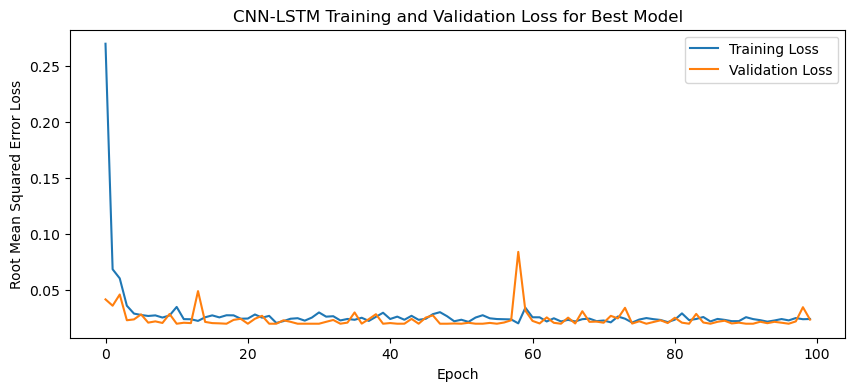

1/1 - 2s - loss: 0.0223 - 2s/epoch - 2s/step
Test Loss: 0.02230805717408657
1/1 [==============================] - 0s 35ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Specific Humidity\tPredicted Specific Humidity\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

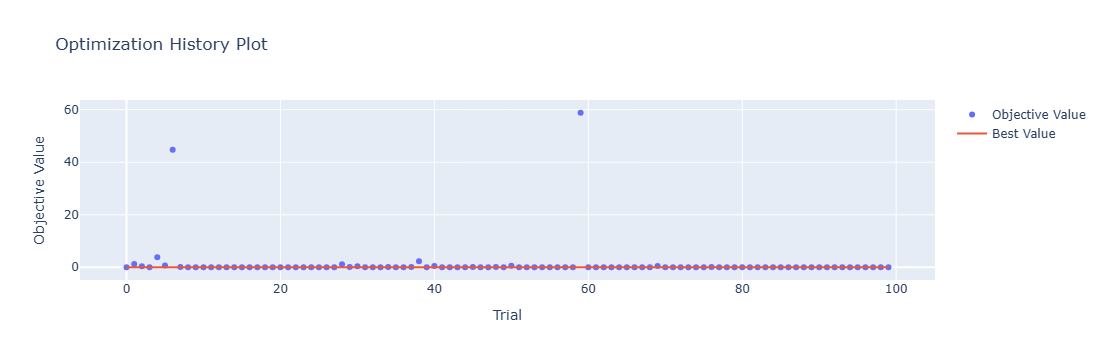

In [4]:
optuna.visualization.plot_optimization_history(study)

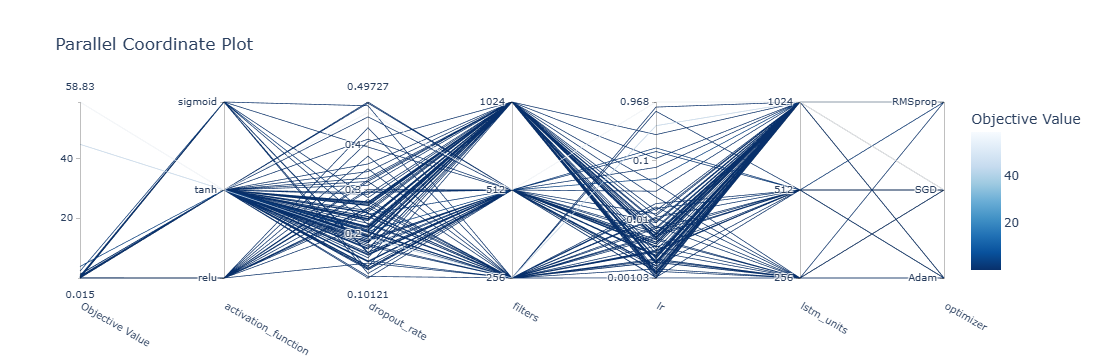

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

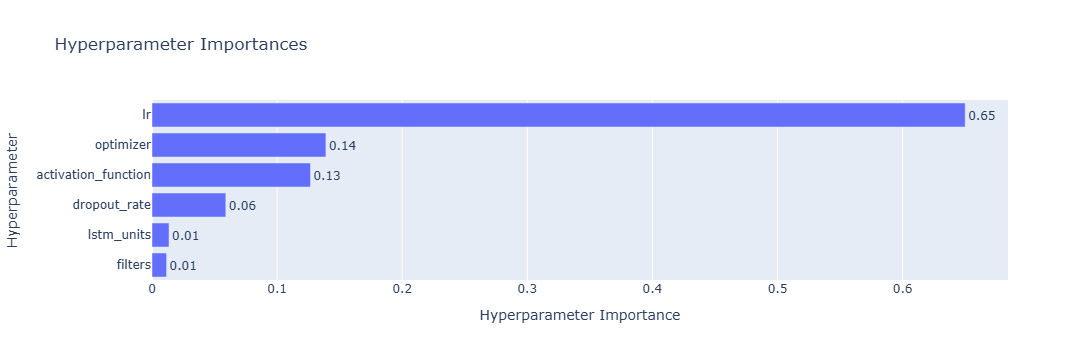

In [6]:
optuna.visualization.plot_param_importances(study)

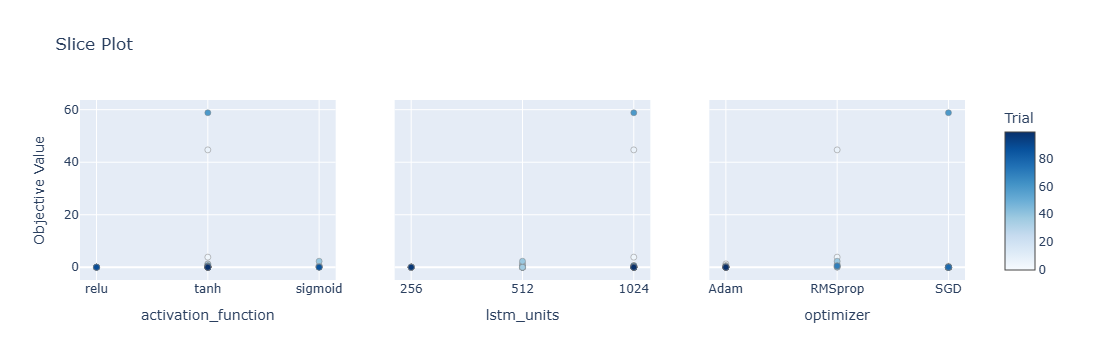

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

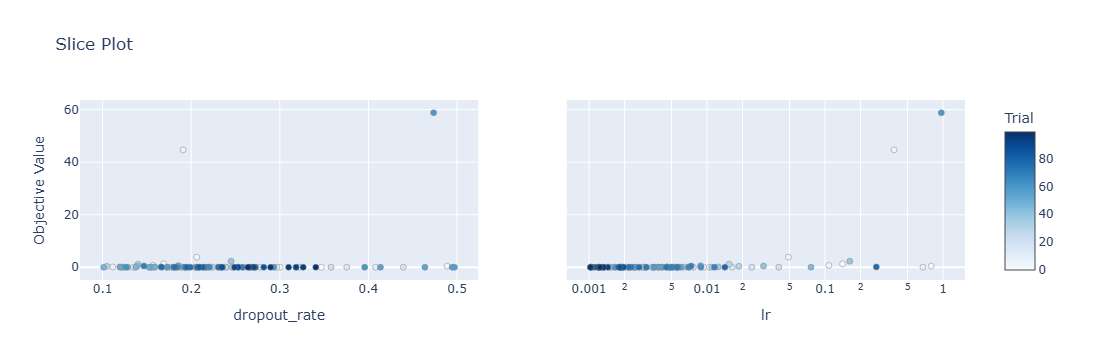

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 12s 94ms/step - loss: 0.2951 - accuracy: 0.0000e+00 - mae: 0.2951 - rmse: 0.2951 - mape: 60.2839 - pearson: nan - val_loss: 0.1160 - val_accuracy: 0.0000e+00 - val_mae: 0.1160 - val_rmse: 0.1160 - val_mape: 24.0286 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 67ms/step - loss: 0.0761 - accuracy: 0.0000e+00 - mae: 0.0761 - rmse: 0.0761 - mape: 15.3413 - pearson: nan - val_loss: 0.0287 - val_accuracy: 0.0000e+00 - val_mae: 0.0287 - val_rmse: 0.0287 - val_mape: 6.0904 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 6s 67ms/step - loss: 0.0506 - accuracy: 0.0000e+00 - mae: 0.0506 - rmse: 0.0506 - mape: 10.1847 - pearson: nan - val_loss: 0.0385 - val_accuracy: 0.0000e+00 - val_mae: 0.0385 - val_rmse: 0.0385 - val_mape: 7.7000 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 78ms/step - loss: 0.0291 - accuracy: 0.0000e+00 - mae: 0.0291 - rmse: 0.0291 - mape: 5.

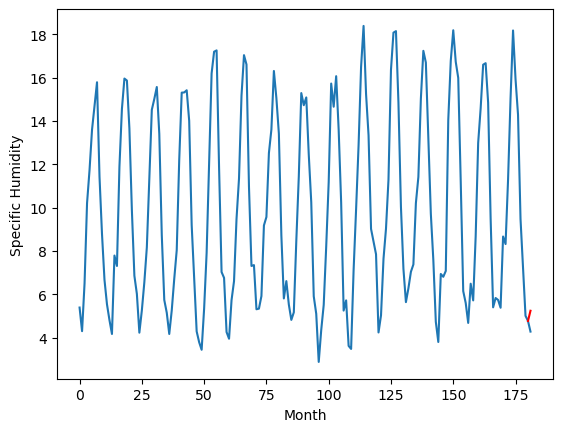

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.93		0.03
[180, 181]
[7.05, 4.932159829139709]


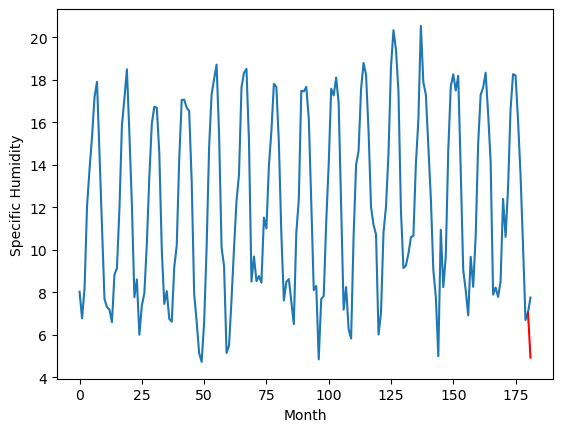

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.82		4.82		0.00
[180, 181]
[5.06, 4.822160782814026]


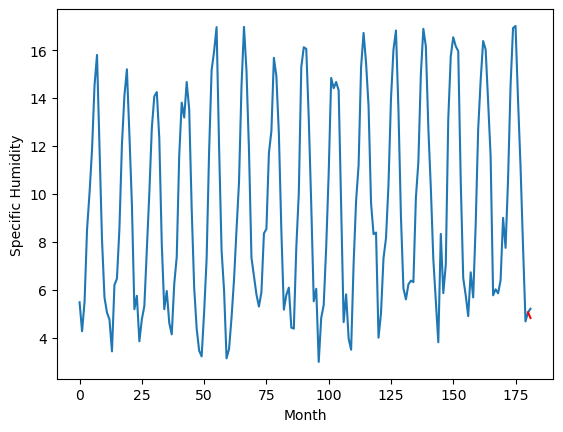

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.21		4.52		0.31
[180, 181]
[7.05, 4.522159829139709]


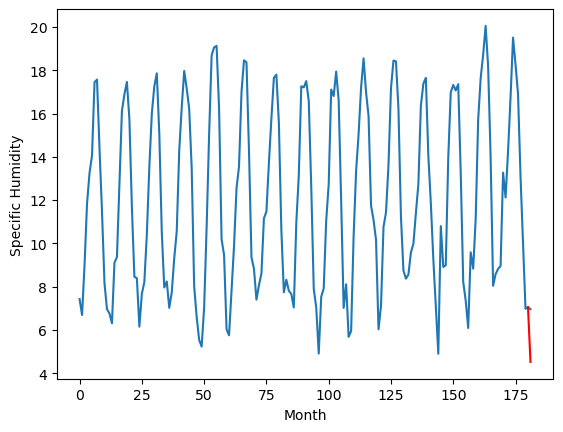

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.32		5.77		0.45
[180, 181]
[5.2, 5.772160782814026]


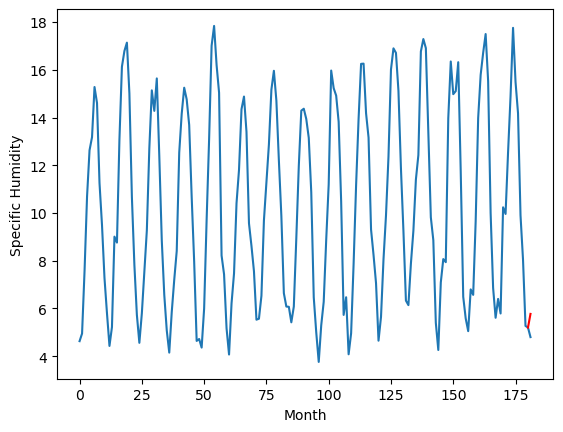

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.42		8.41		0.99
[180, 181]
[5.16, 8.412160782814025]


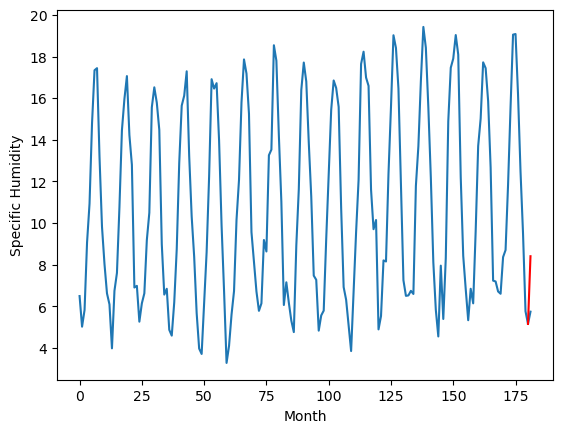

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.33		5.86		0.53
[180, 181]
[4.05, 5.862161766290665]


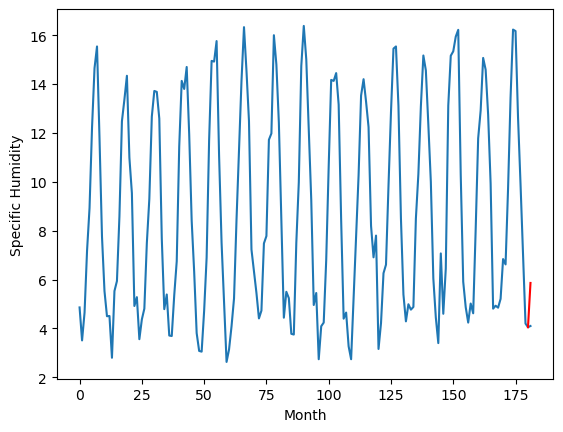

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.12		7.81		0.69
[180, 181]
[3.64, 7.812160782814026]


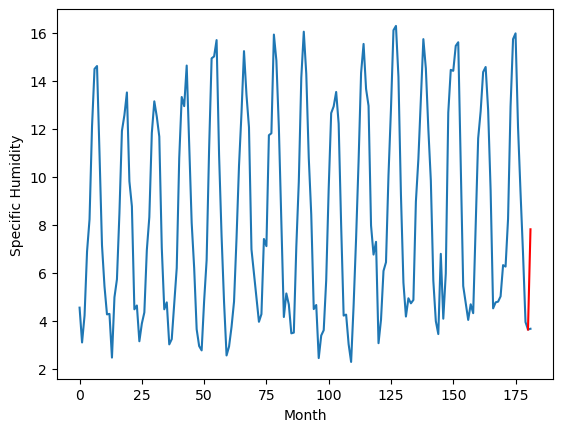

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.40		5.01		0.61
[180, 181]
[3.46, 5.012160782814026]


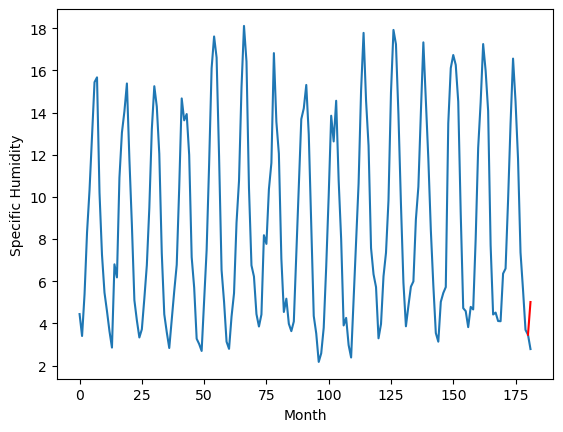

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.17		6.88		0.71
[180, 181]
[2.93, 6.882160782814026]


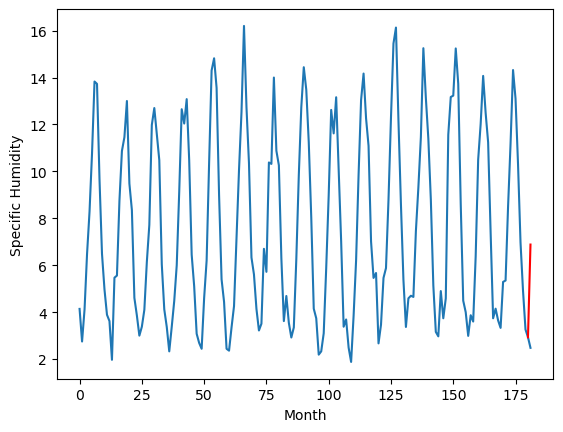

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		5.24		0.76
[180, 181]
[2.74, 5.242160782814026]


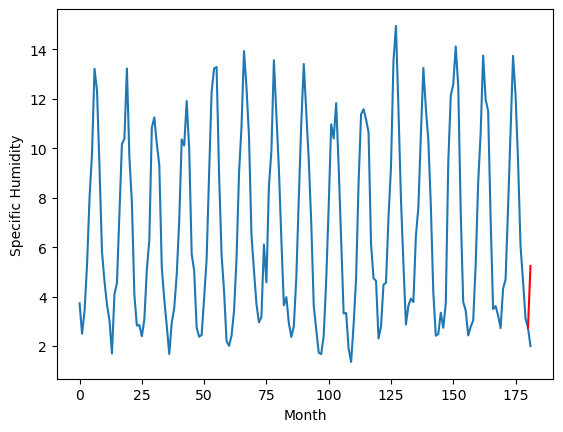

RangeIndex(start=1, stop=12, step=1)
[4.62, 4.899999999999999, 4.820000000000001, 4.209999999999998, 5.32, 7.42, 5.33, 7.119999999999999, 4.4, 6.170000000000001, 4.48]
[5.242160782814026, 4.932159829139709, 4.822160782814026, 4.522159829139709, 5.772160782814026, 8.412160782814025, 5.862161766290665, 7.812160782814026, 5.012160782814026, 6.882160782814026, 5.242160782814026]


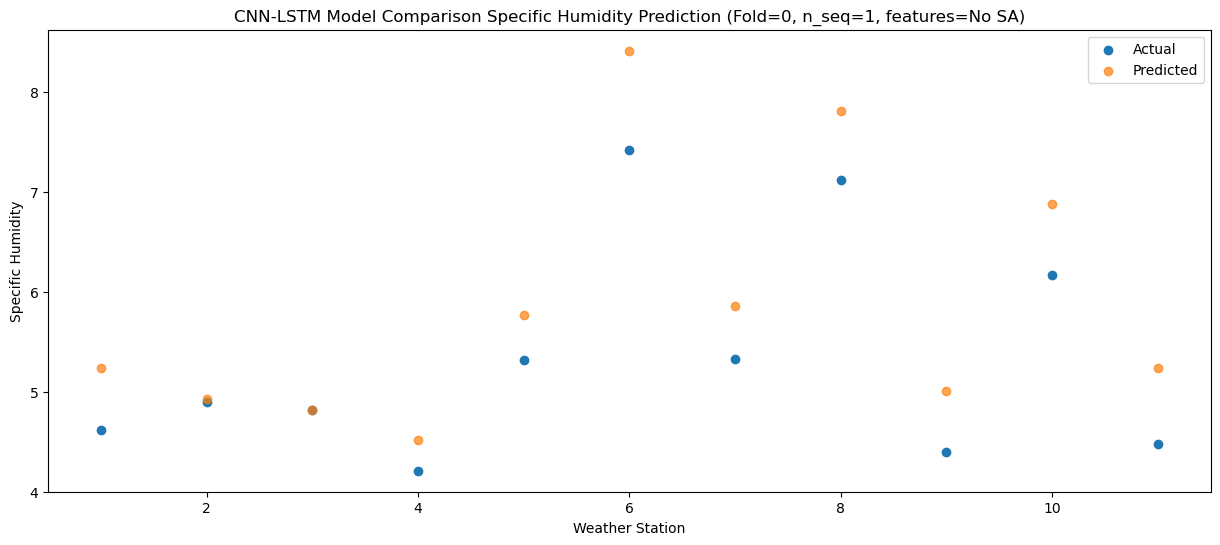

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 1024)           8392704   
                                                                 
 dropout_16 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_11 (LSTM)              (None, 1024)              8392704   
                                                      

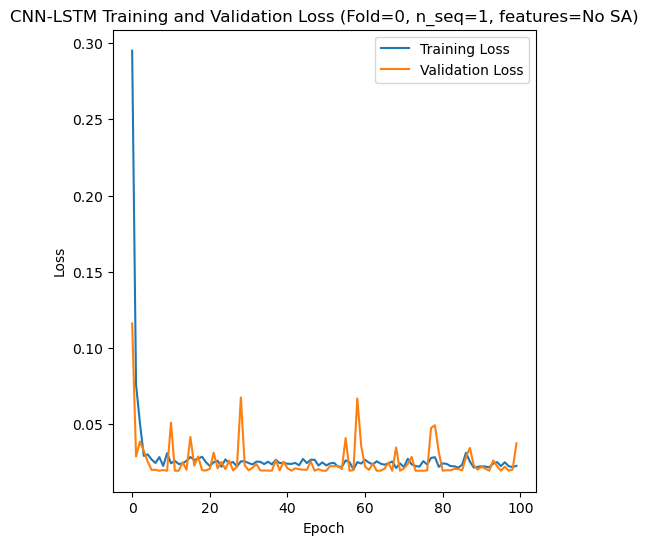

Epoch 1/100
84/84 [==============================] - 22s 123ms/step - loss: 0.2860 - accuracy: 0.0000e+00 - mae: 0.2860 - rmse: 0.2860 - mape: 57.9914 - pearson: nan - val_loss: 0.0576 - val_accuracy: 0.0000e+00 - val_mae: 0.0576 - val_rmse: 0.0576 - val_mape: 11.6782 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0673 - accuracy: 0.0000e+00 - mae: 0.0673 - rmse: 0.0673 - mape: 13.5780 - pearson: nan - val_loss: 0.0617 - val_accuracy: 0.0000e+00 - val_mae: 0.0617 - val_rmse: 0.0617 - val_mape: 12.5188 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 82ms/step - loss: 0.0435 - accuracy: 0.0000e+00 - mae: 0.0435 - rmse: 0.0435 - mape: 8.7301 - pearson: nan - val_loss: 0.0166 - val_accuracy: 0.0000e+00 - val_mae: 0.0166 - val_rmse: 0.0166 - val_mape: 3.4743 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 83ms/step - loss: 0.0372 - accuracy: 0.0000e+00 - mae: 0.0372 - rmse: 0.0372 - mape: 7

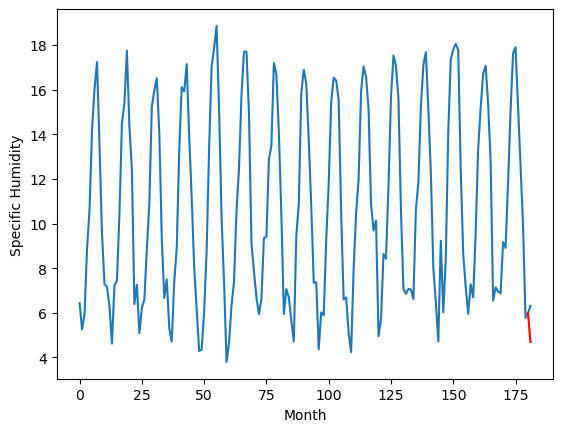

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		4.20		-0.14
[180, 181]
[4.15, 4.199765868186951]


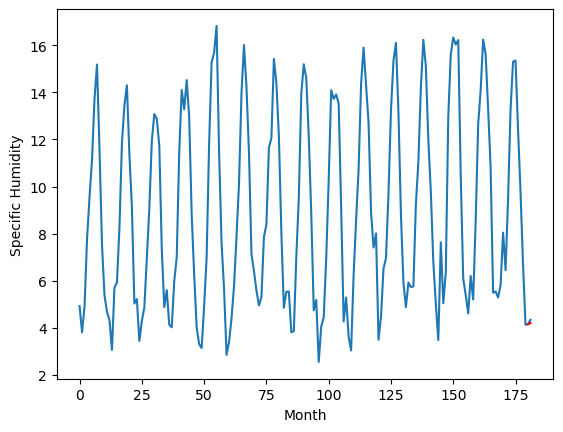

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		2.95		-0.27
[180, 181]
[5.12, 2.9497678053379057]


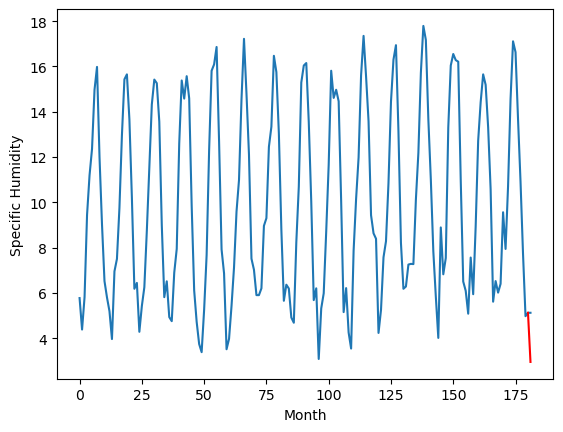

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		2.25		0.22
[180, 181]
[6.35, 2.249767805337906]


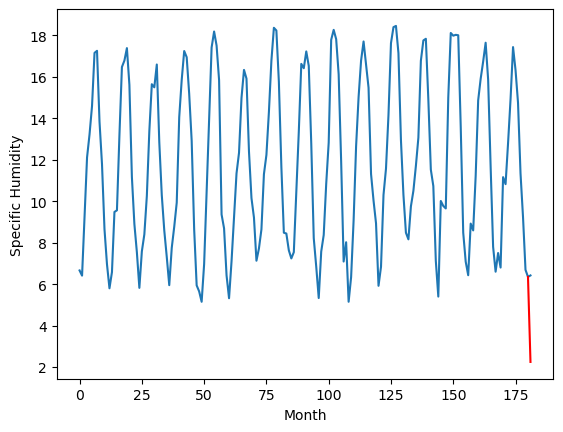

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		6.31		0.13
[180, 181]
[6.08, 6.309766836762428]


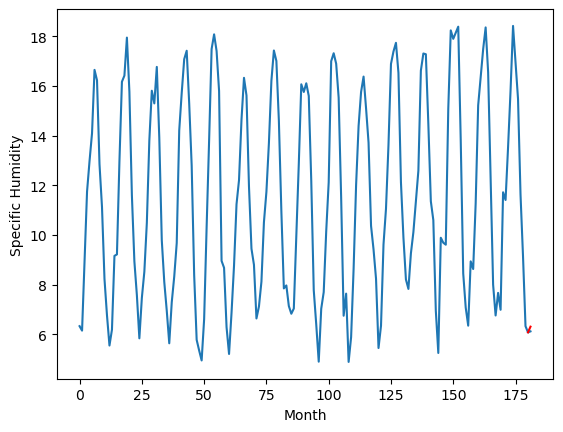

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		4.80		-0.95
[180, 181]
[3.92, 4.799767805337906]


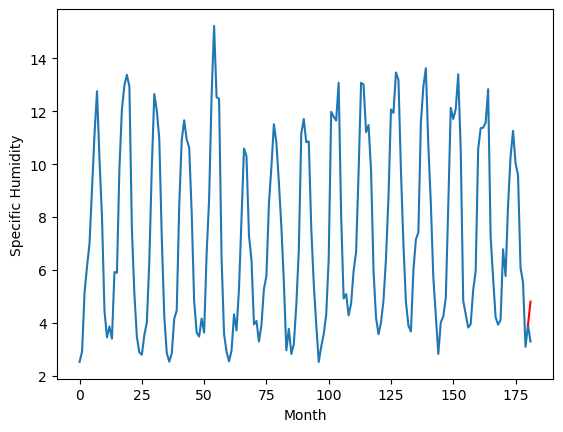

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		5.65		-0.01
[180, 181]
[4.16, 5.649766836762428]


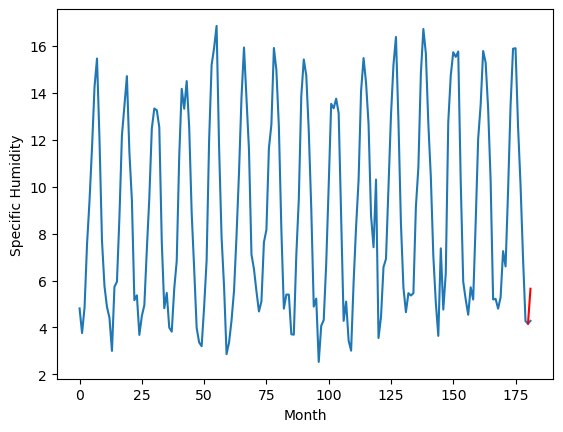

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		6.54		0.01
[180, 181]
[3.84, 6.539766836762428]


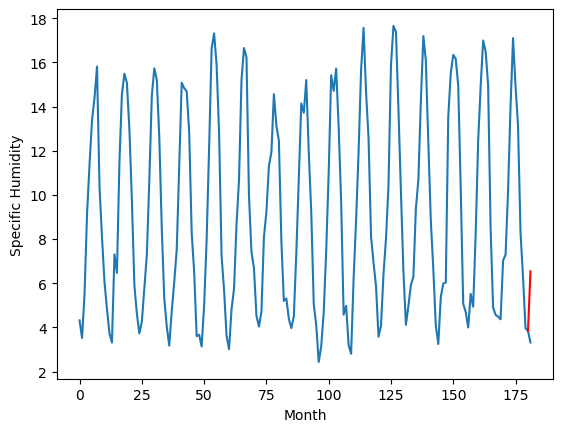

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		6.21		-0.28
[180, 181]
[3.73, 6.209766836762428]


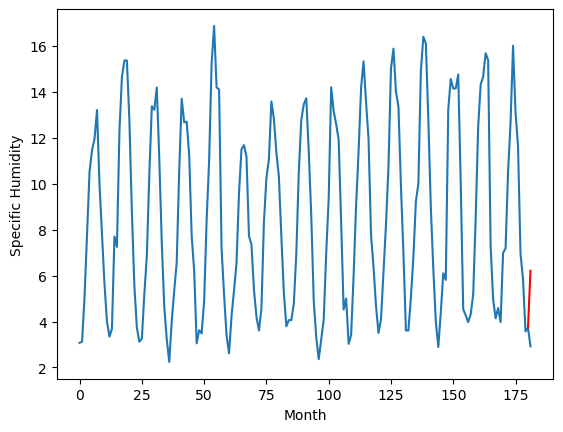

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		2.40		-0.31
[180, 181]
[2.83, 2.399767805337906]


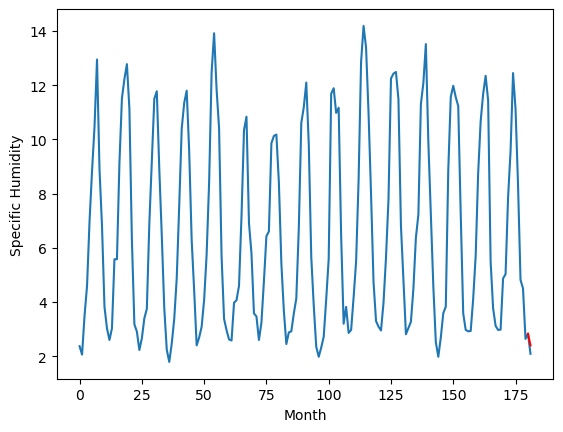

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		4.69		0.61
[180, 181]
[2.69, 4.689766836762428]


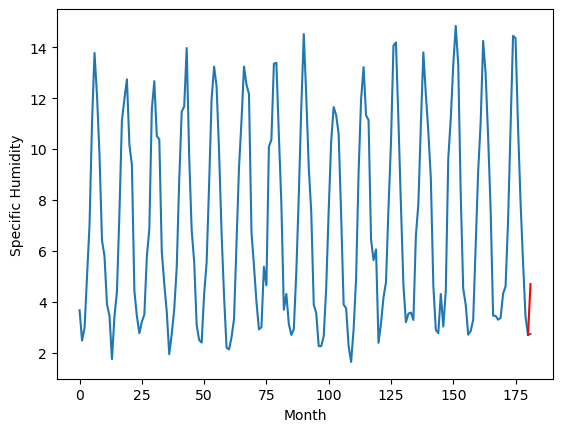

RangeIndex(start=1, stop=12, step=1)
[5.03, 4.340000000000002, 3.2199999999999998, 2.0299999999999994, 6.18, 5.75, 5.66, 6.529999999999999, 6.49, 2.7100000000000004, 4.079999999999999]
[4.689766836762428, 4.199765868186951, 2.9497678053379057, 2.249767805337906, 6.309766836762428, 4.799767805337906, 5.649766836762428, 6.539766836762428, 6.209766836762428, 2.399767805337906, 4.689766836762428]


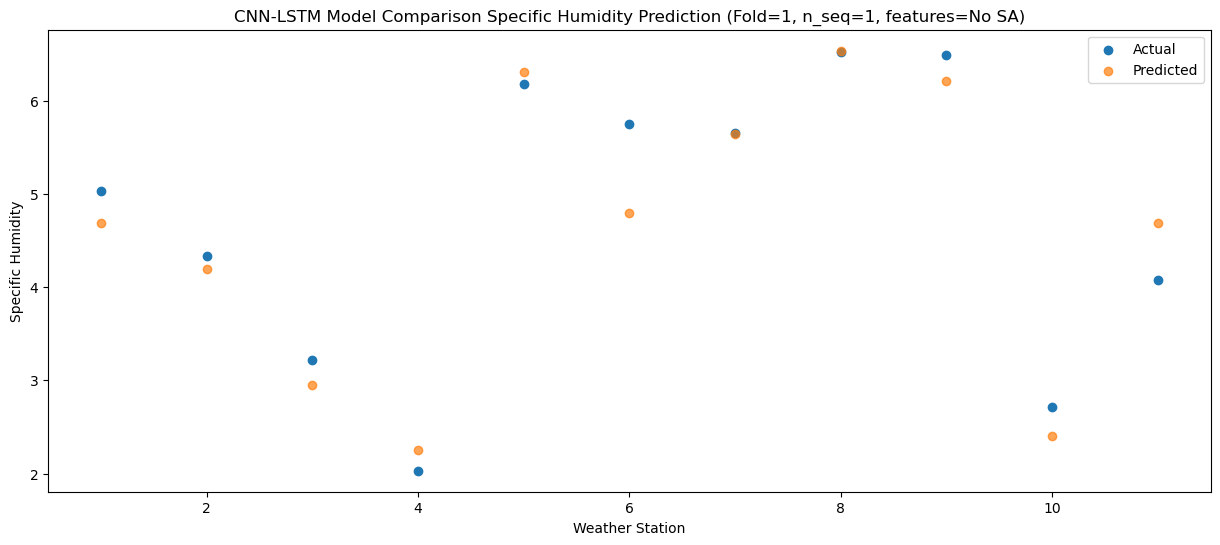

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 1024)           8392704   
                                                                 
 dropout_19 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_13 (LSTM)              (None, 1024)              8392704   
                                                      

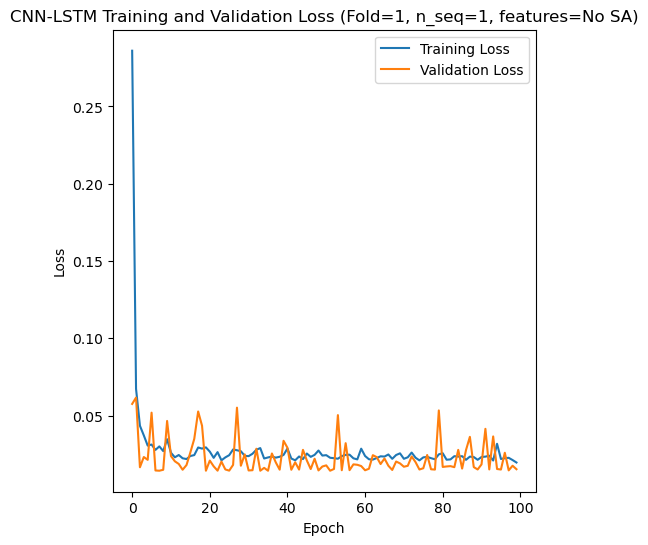

Epoch 1/100
84/84 [==============================] - 22s 120ms/step - loss: 0.3347 - accuracy: 0.0000e+00 - mae: 0.3347 - rmse: 0.3347 - mape: 67.8924 - pearson: nan - val_loss: 0.0256 - val_accuracy: 0.0000e+00 - val_mae: 0.0256 - val_rmse: 0.0256 - val_mape: 5.5025 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 76ms/step - loss: 0.0992 - accuracy: 0.0000e+00 - mae: 0.0992 - rmse: 0.0992 - mape: 19.8193 - pearson: nan - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - val_mae: 0.0211 - val_rmse: 0.0211 - val_mape: 4.5535 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0353 - accuracy: 0.0000e+00 - mae: 0.0353 - rmse: 0.0353 - mape: 7.0688 - pearson: nan - val_loss: 0.0561 - val_accuracy: 0.0000e+00 - val_mae: 0.0561 - val_rmse: 0.0561 - val_mape: 11.5593 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 6s 76ms/step - loss: 0.0336 - accuracy: 0.0000e+00 - mae: 0.0336 - rmse: 0.0336 - mape: 6.

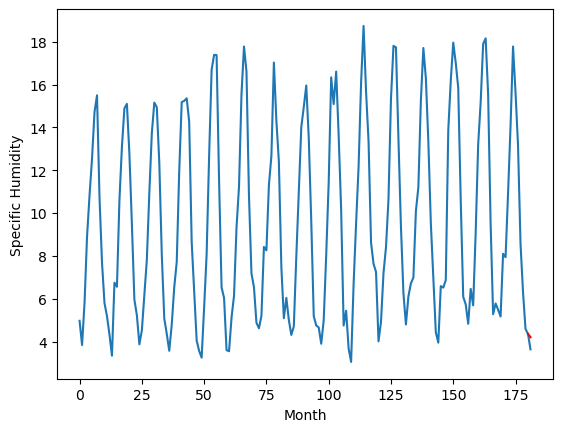

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		1.47		-0.37
[180, 181]
[2.82, 1.4732911431789397]


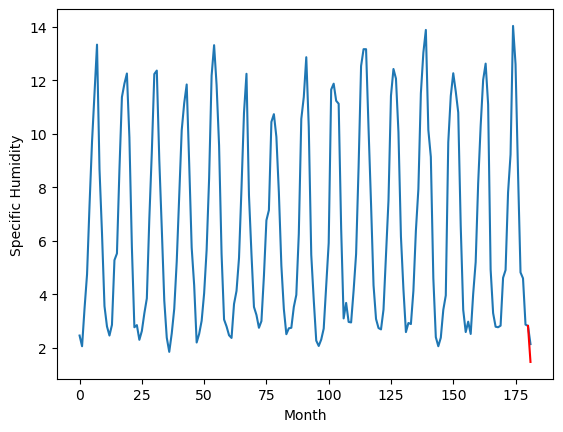

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		4.62		-0.91
[180, 181]
[9.16, 4.62329114317894]


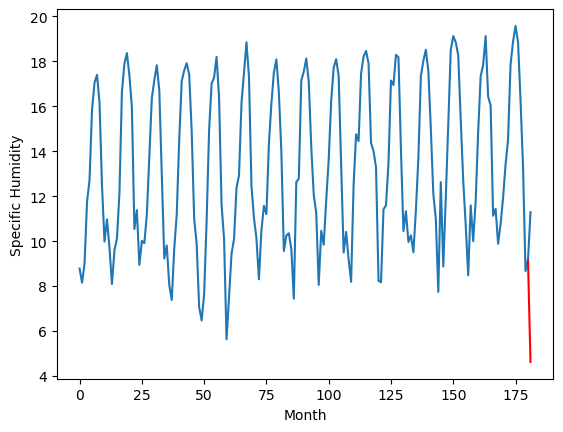

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.64		0.66
[180, 181]
[2.44, 4.643290189504623]


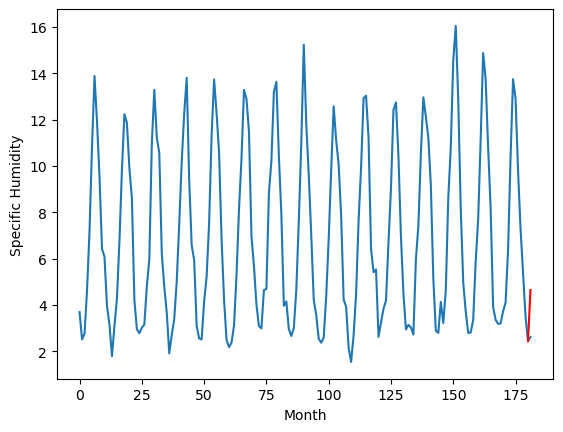

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		4.55		-0.55
[180, 181]
[6.65, 4.553290189504623]


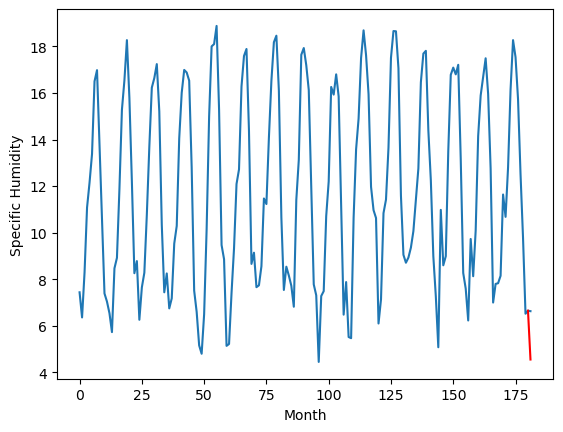

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.04		-0.29
[180, 181]
[6.19, 2.0432901895046234]


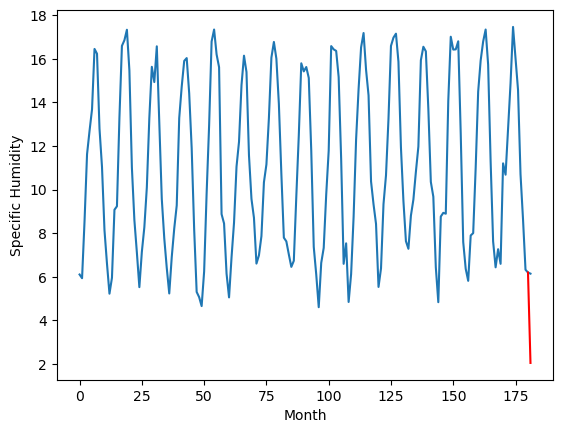

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.36		-0.32
[180, 181]
[4.78, 8.36329114317894]


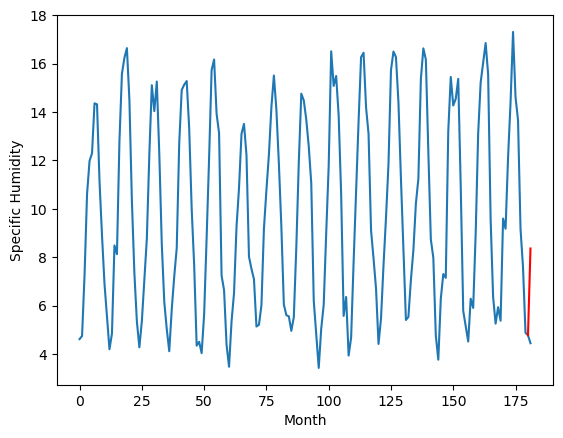

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.27		-0.70
[180, 181]
[2.61, 3.2732911431789398]


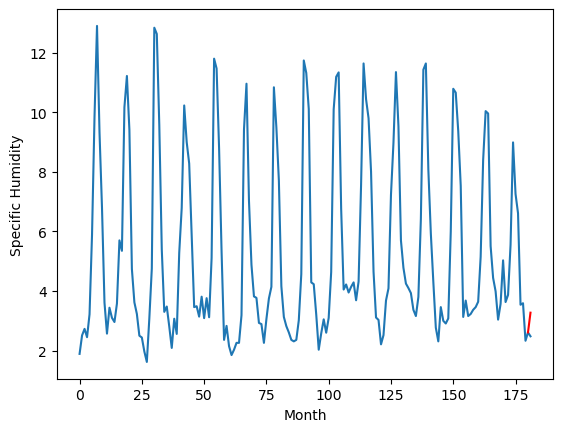

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.02		-1.27
[180, 181]
[4.6, 7.023290189504624]


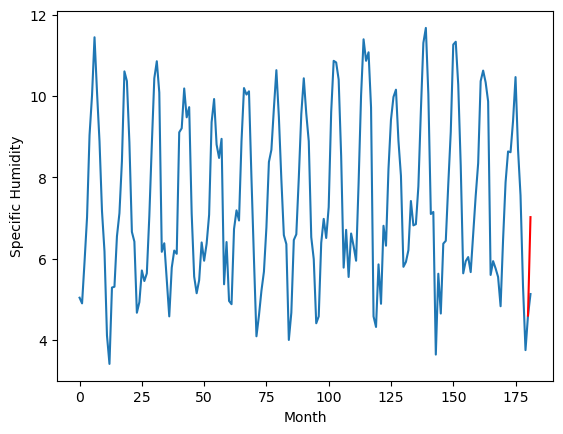

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.68		-0.30
[180, 181]
[4.27, 5.683290189504623]


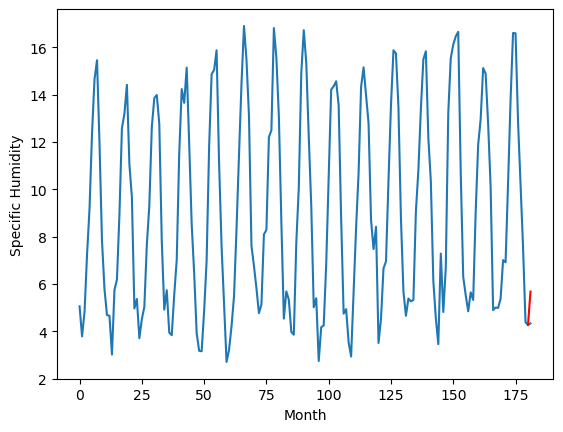

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.20		-0.43
[180, 181]
[3.91, 4.2032901895046235]


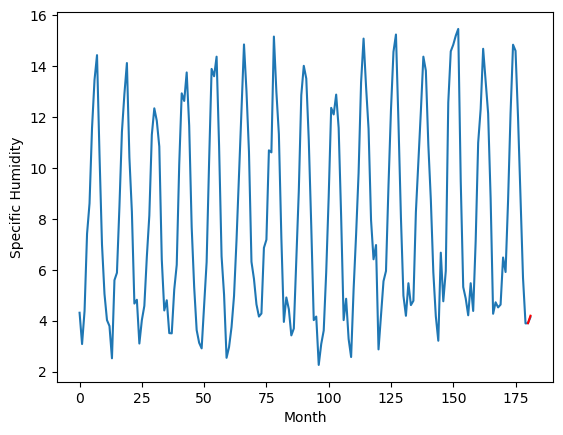

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.2032901895046235, 1.4732911431789397, 4.62329114317894, 4.643290189504623, 4.553290189504623, 2.0432901895046234, 8.36329114317894, 3.2732911431789398, 7.023290189504624, 5.683290189504623, 4.2032901895046235]


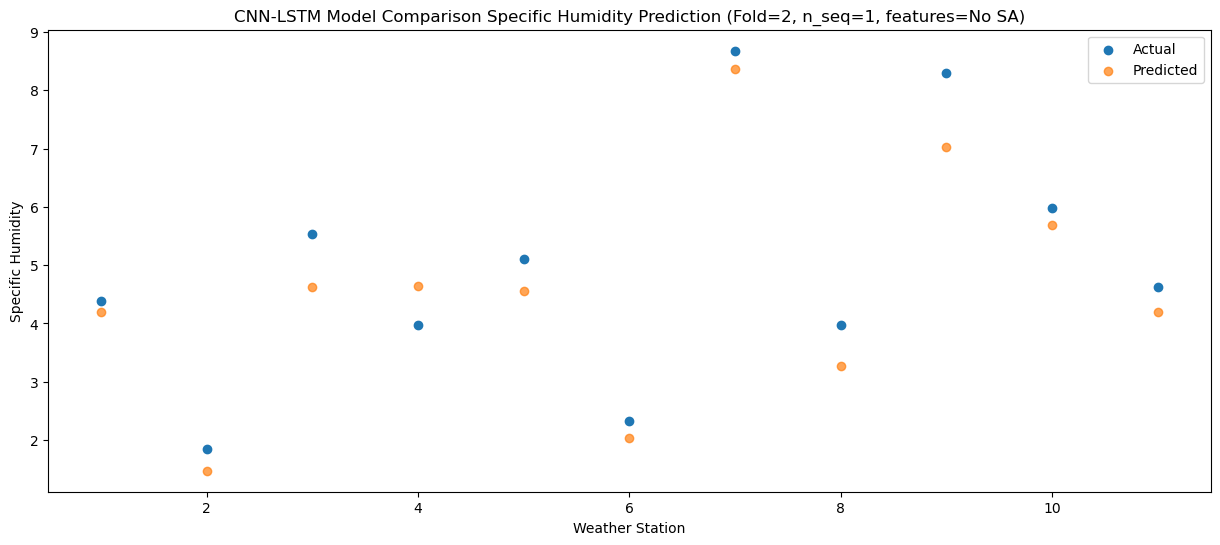

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 1024)           8392704   
                                                                 
 dropout_22 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_15 (LSTM)              (None, 1024)              8392704   
                                                      

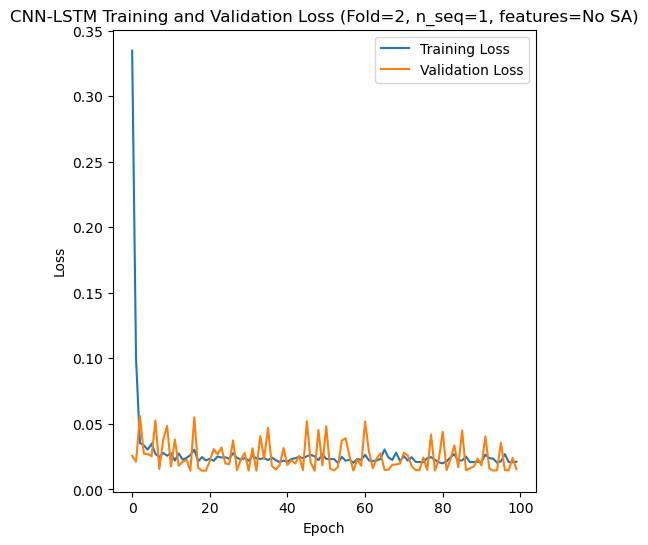

Epoch 1/100
84/84 [==============================] - 22s 129ms/step - loss: 0.2270 - accuracy: 0.0000e+00 - mae: 0.2270 - rmse: 0.2270 - mape: 46.1401 - pearson: nan - val_loss: 0.0413 - val_accuracy: 0.0000e+00 - val_mae: 0.0413 - val_rmse: 0.0413 - val_mape: 7.9967 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 76ms/step - loss: 0.0762 - accuracy: 0.0000e+00 - mae: 0.0762 - rmse: 0.0762 - mape: 15.4030 - pearson: nan - val_loss: 0.0375 - val_accuracy: 0.0000e+00 - val_mae: 0.0375 - val_rmse: 0.0375 - val_mape: 7.5973 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 84ms/step - loss: 0.0466 - accuracy: 0.0000e+00 - mae: 0.0466 - rmse: 0.0466 - mape: 9.3709 - pearson: nan - val_loss: 0.0245 - val_accuracy: 0.0000e+00 - val_mae: 0.0245 - val_rmse: 0.0245 - val_mape: 4.6649 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0391 - accuracy: 0.0000e+00 - mae: 0.0391 - rmse: 0.0391 - mape: 7.9

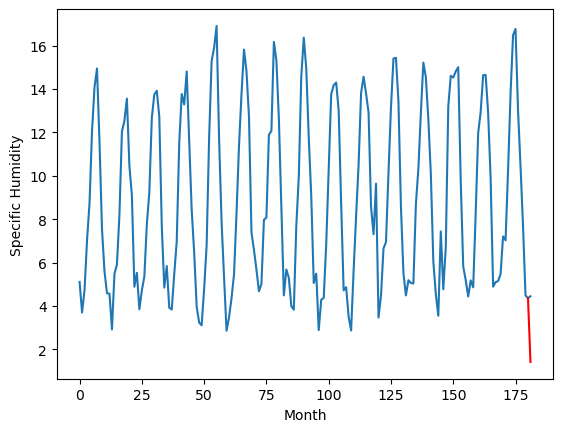

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.64		2.46		-0.18
[180, 181]
[3.43, 2.462988715171814]


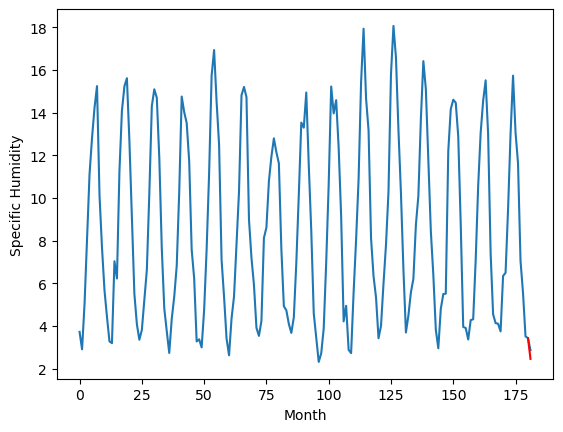

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.37		5.66		-0.71
[180, 181]
[5.43, 5.662989192008972]


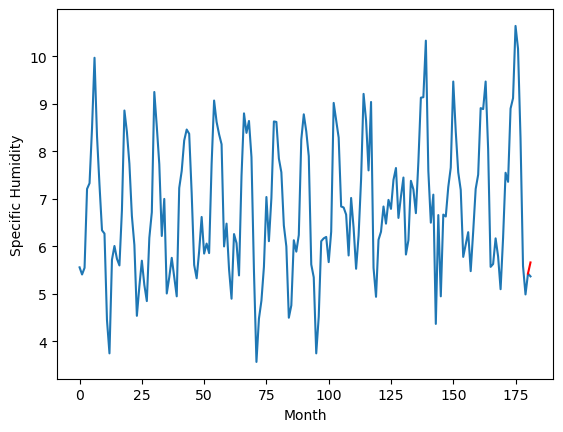

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.44		3.44		0.00
[180, 181]
[3.21, 3.442988715171814]


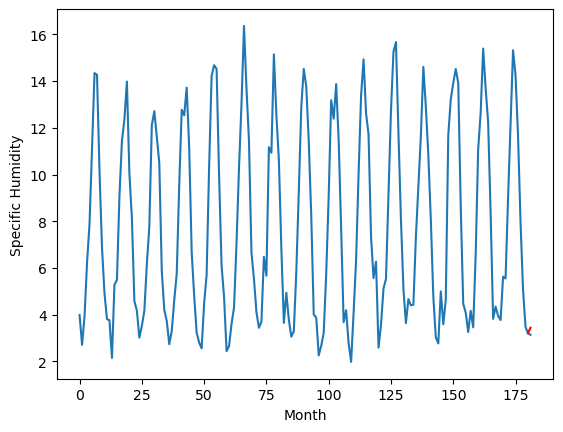

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.91		4.84		-0.07
[180, 181]
[3.04, 4.842987761497498]


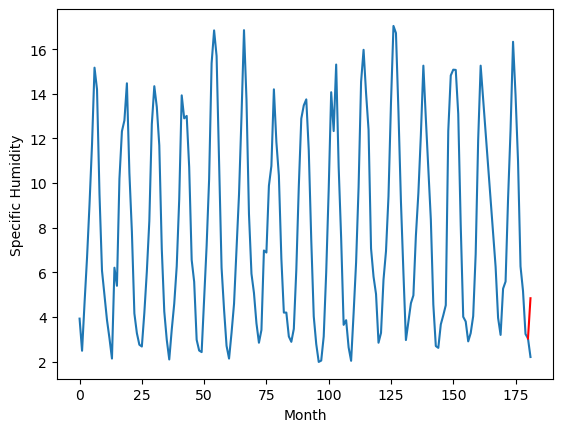

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.42		3.46		0.04
[180, 181]
[2.91, 3.4629877614974975]


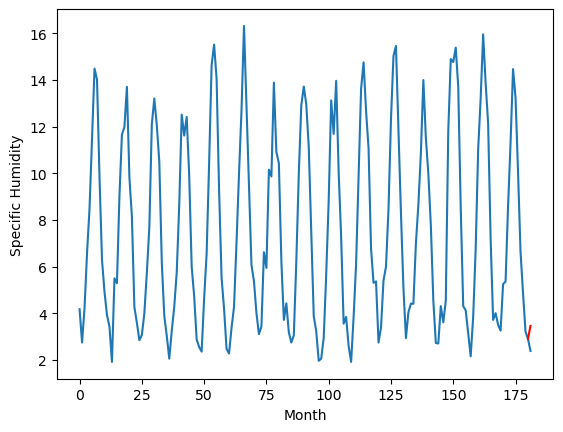

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.73		5.29		-0.44
[180, 181]
[1.6, 5.292989192008972]


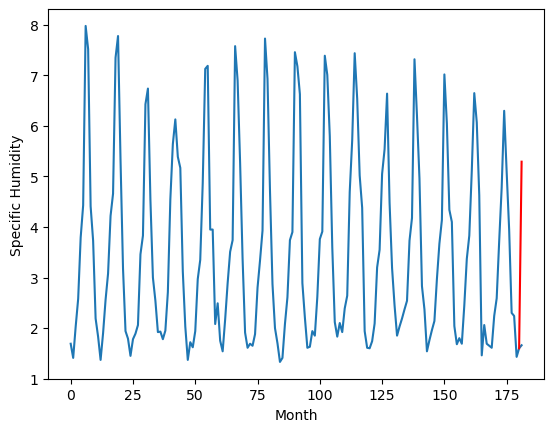

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.80		3.72		-1.08
[180, 181]
[2.86, 3.7229891920089724]


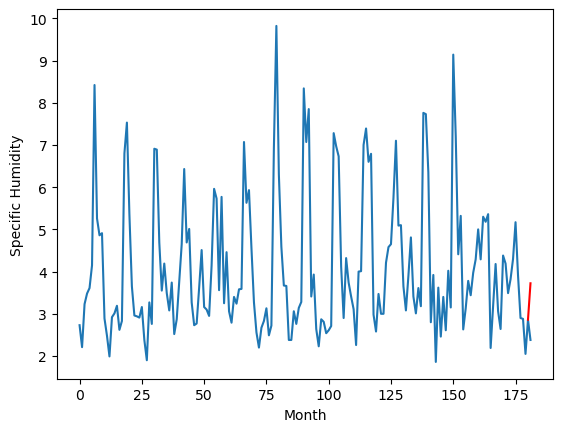

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.60		3.66		-0.94
[180, 181]
[5.65, 3.662988715171814]


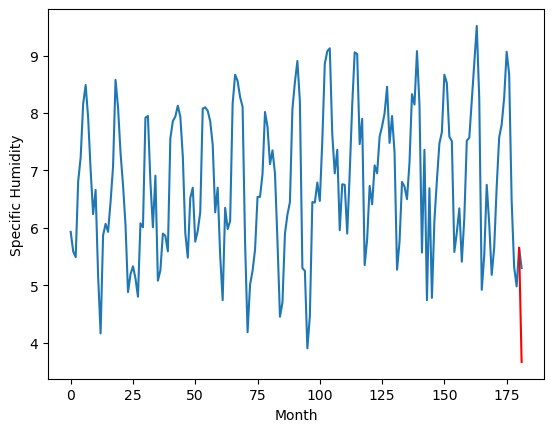

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.09		3.91		0.82
[180, 181]
[2.54, 3.9129887151718137]


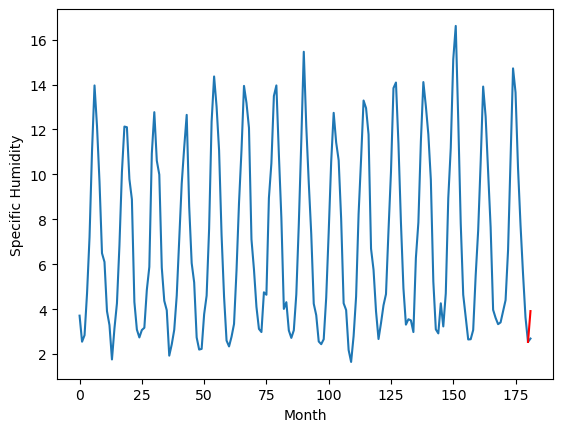

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.00		1.42		0.42
[180, 181]
[2.51, 1.422988715171814]


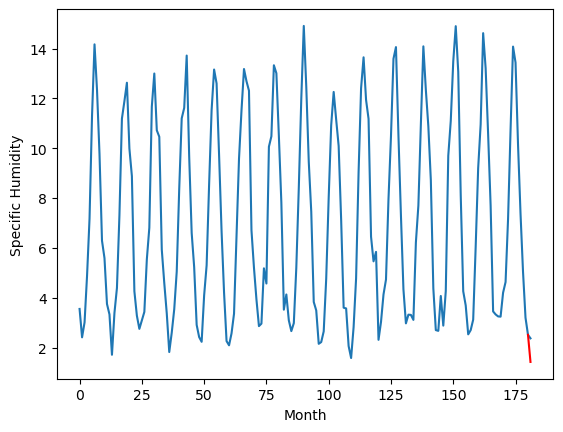

RangeIndex(start=1, stop=12, step=1)
[1.5600000000000005, 2.64, 6.369999999999998, 3.4399999999999995, 4.91, 3.42, 5.73, 4.800000000000001, 4.6, 3.09, 0.9999999999999993]
[1.4229891920089721, 2.462988715171814, 5.662989192008972, 3.442988715171814, 4.842987761497498, 3.4629877614974975, 5.292989192008972, 3.7229891920089724, 3.662988715171814, 3.9129887151718137, 1.422988715171814]


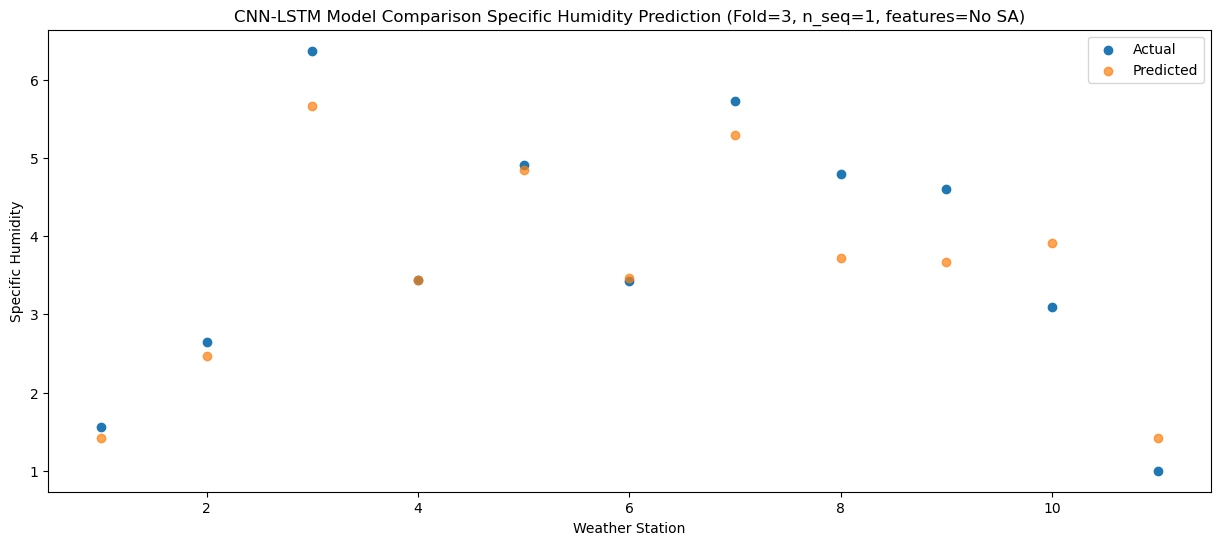

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_24 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 1024)           8392704   
                                                                 
 dropout_25 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_17 (LSTM)              (None, 1024)              8392704   
                                                      

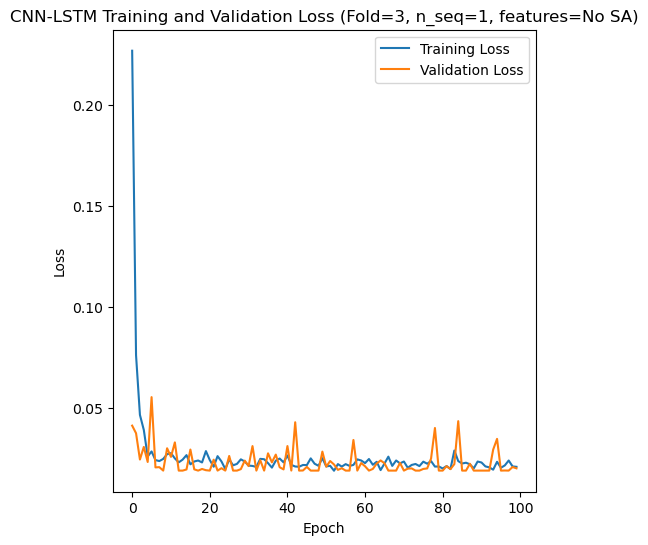

Epoch 1/100
84/84 [==============================] - 23s 121ms/step - loss: 0.2763 - accuracy: 0.0000e+00 - mae: 0.2763 - rmse: 0.2763 - mape: 56.4844 - pearson: nan - val_loss: 0.1735 - val_accuracy: 0.0000e+00 - val_mae: 0.1735 - val_rmse: 0.1735 - val_mape: 34.6848 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 79ms/step - loss: 0.0861 - accuracy: 0.0000e+00 - mae: 0.0861 - rmse: 0.0861 - mape: 17.4894 - pearson: nan - val_loss: 0.0592 - val_accuracy: 0.0000e+00 - val_mae: 0.0592 - val_rmse: 0.0592 - val_mape: 12.1607 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 77ms/step - loss: 0.0356 - accuracy: 0.0000e+00 - mae: 0.0356 - rmse: 0.0356 - mape: 7.1768 - pearson: nan - val_loss: 0.0366 - val_accuracy: 0.0000e+00 - val_mae: 0.0366 - val_rmse: 0.0366 - val_mape: 7.1637 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0420 - accuracy: 0.0000e+00 - mae: 0.0420 - rmse: 0.0420 - mape: 8

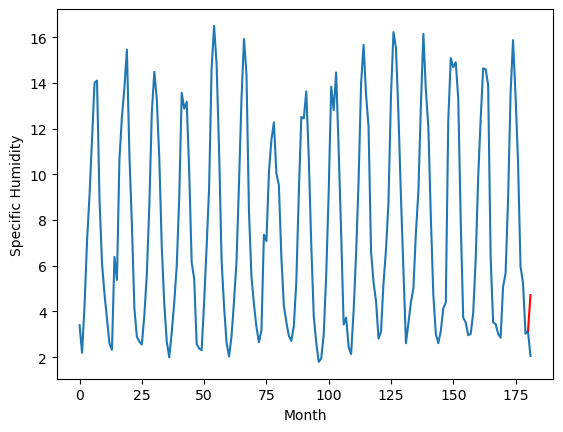

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		3.42		-0.85
[180, 181]
[7.79, 3.416824324131012]


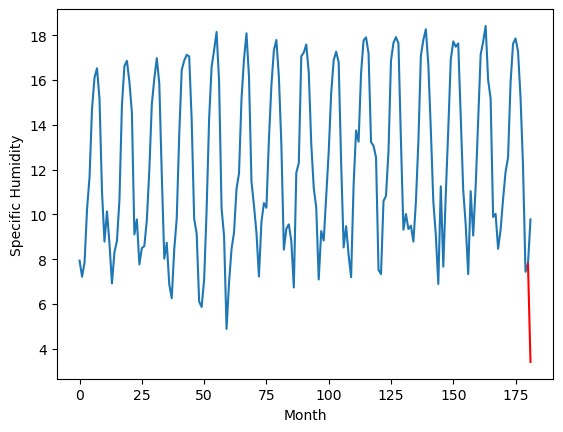

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		3.48		-0.39
[180, 181]
[5.03, 3.476824324131012]


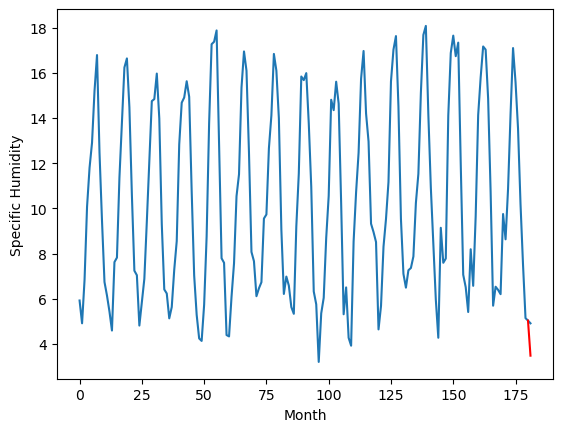

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		3.34		-0.39
[180, 181]
[4.41, 3.3368252778053282]


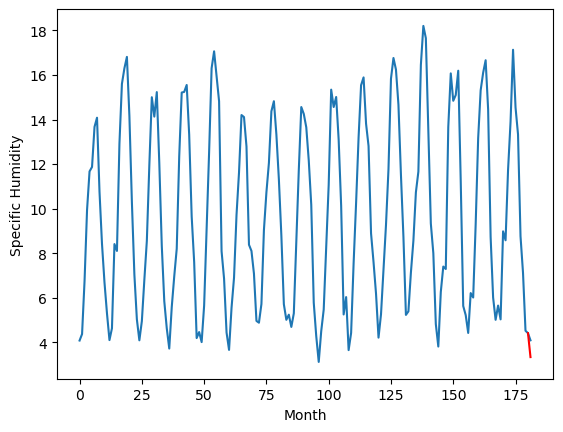

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		2.90		-0.46
[180, 181]
[4.29, 2.896824324131012]


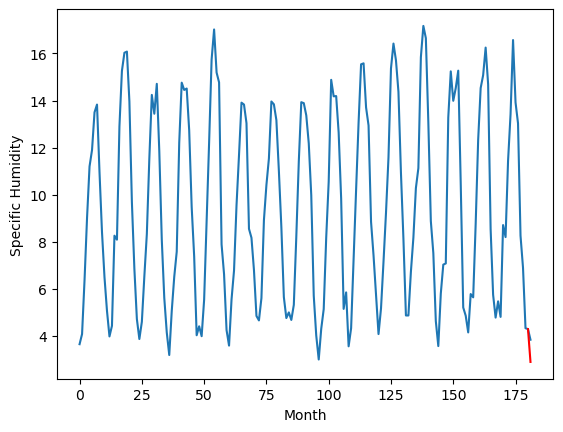

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		7.44		-1.20
[180, 181]
[3.47, 7.436825277805329]


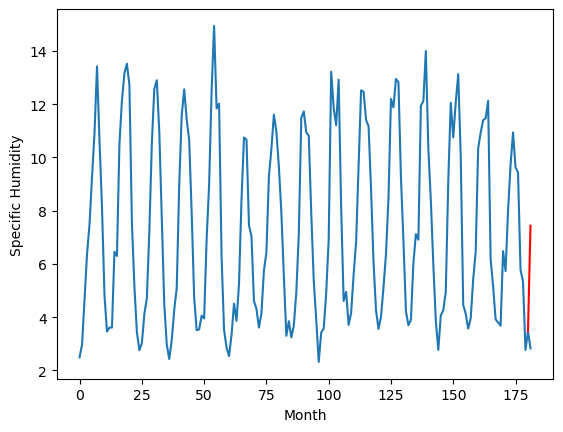

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		5.42		-0.38
[180, 181]
[4.52, 5.416825277805328]


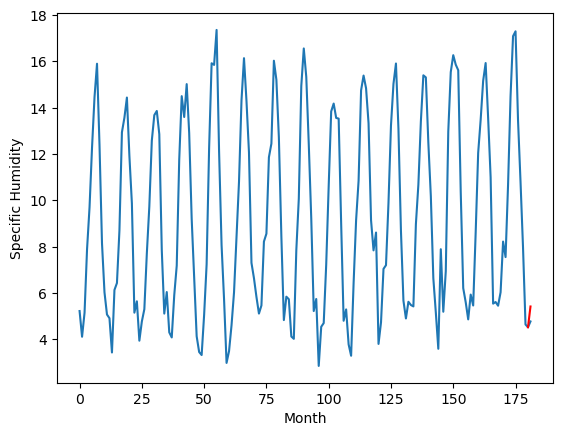

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		3.58		-0.35
[180, 181]
[3.4, 3.5768252778053284]


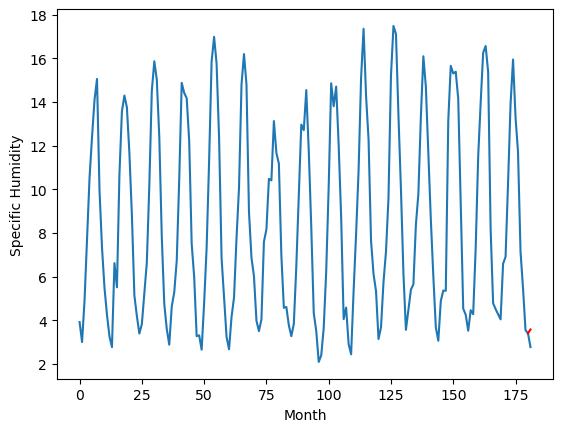

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		3.15		-0.15
[180, 181]
[2.82, 3.1468252778053283]


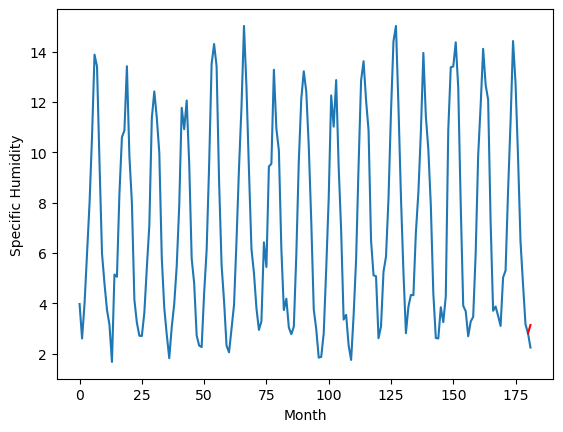

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		1.99		-0.18
[180, 181]
[2.86, 1.986826231479645]


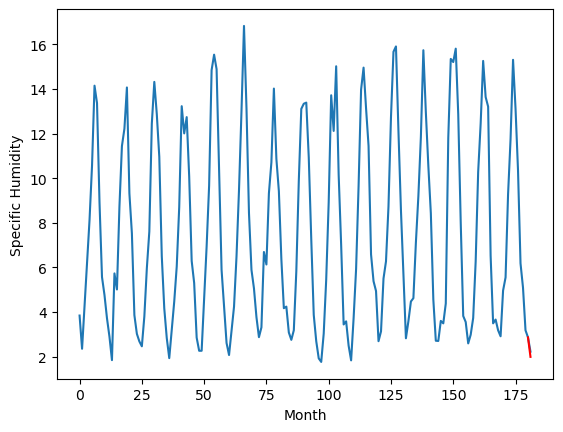

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		4.72		-0.12
[180, 181]
[2.61, 4.716825277805328]


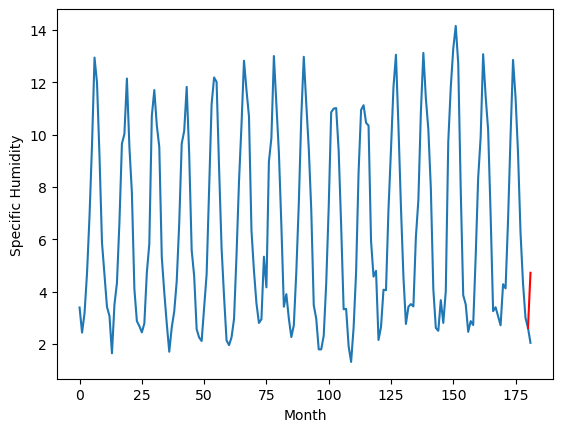

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[4.7168262314796445, 3.416824324131012, 3.476824324131012, 3.3368252778053282, 2.896824324131012, 7.436825277805329, 5.416825277805328, 3.5768252778053284, 3.1468252778053283, 1.986826231479645, 4.716825277805328]


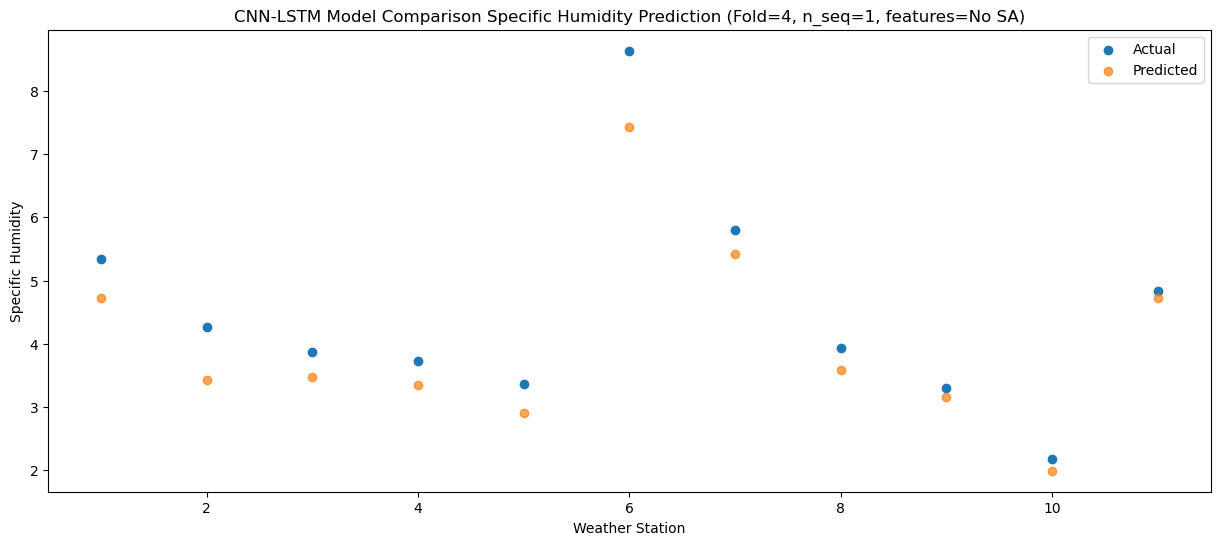

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_27 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 1024)           8392704   
                                                                 
 dropout_28 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_19 (LSTM)              (None, 1024)              8392704   
                                                      

[[0.5953978557449763], [0.39580970455407755], [0.6232527830260943], [0.5753629299236618], [0.5585151794214991]]
[[0.520342517007481], [0.29733622919429475], [0.5418531345237384], [0.4391847224669023], [0.4659020816196095]]
[[0.09602406381235537], [0.07170944167066452], [0.11902321688468799], [0.13514772218097518], [0.10116597073544821]]
[[0.6768330927339496], [0.9301182384907123], [0.9057496461379783], [0.8707689611844613], [0.8824130219407884]]
[[[5.242160782814026], [4.932159829139709], [4.822160782814026], [4.522159829139709], [5.772160782814026], [8.412160782814025], [5.862161766290665], [7.812160782814026], [5.012160782814026], [6.882160782814026], [5.242160782814026]], [[4.689766836762428], [4.199765868186951], [2.9497678053379057], [2.249767805337906], [6.309766836762428], [4.799767805337906], [5.649766836762428], [6.539766836762428], [6.209766836762428], [2.399767805337906], [4.689766836762428]], [[4.2032901895046235], [1.4732911431789397], [4.62329114317894], [4.64329018950462

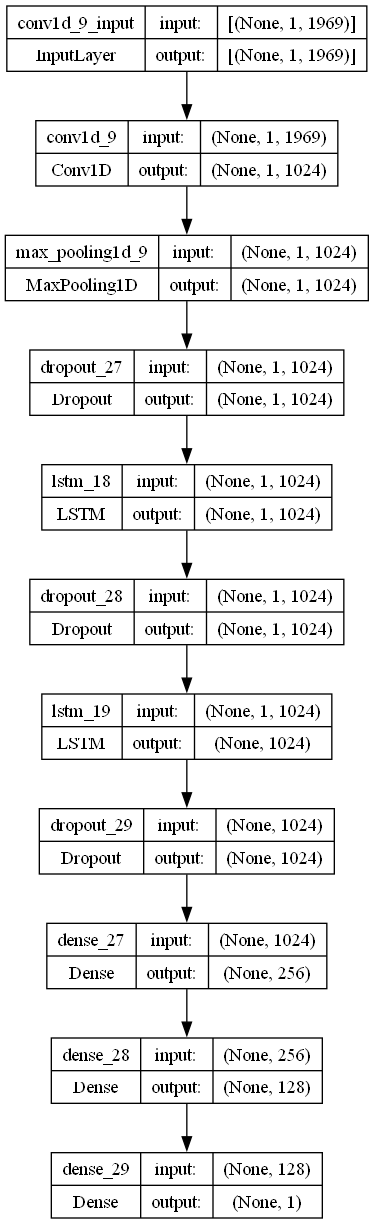

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.001880555165008262
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.2090095399938167

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    # Plotting the results
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['ws'], results_df['Actual'], label='Actual')
    plt.scatter(results_df['ws'], results_df['Predicted'], label='Predicted', alpha=0.7)
    title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
    plt.title(title1)
    plt.xlabel('Weather Station')
    plt.ylabel('Specific Humidity')
    plt.legend()
    plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S1_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)